0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Step 0: : 1it [00:01,  1.44s/it]

Loading pose model from ../models/pose/alpha_pose/fast_res50_256x192.pth...
Loading YOLOX-X model..


/projects/Deep-Learning-For-Computer-Vision-org/keypoint_tracking/../pose-tracking/posedet_alpha/detector_alpha.py:299: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  inps = torch.tensor(inps)
Step 20: : 22it [00:07,  3.88it/s]/tmp/ipykernel_5055/3033498075.py:336: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
Step 34: : 36it [00:11,  4.03it/s]

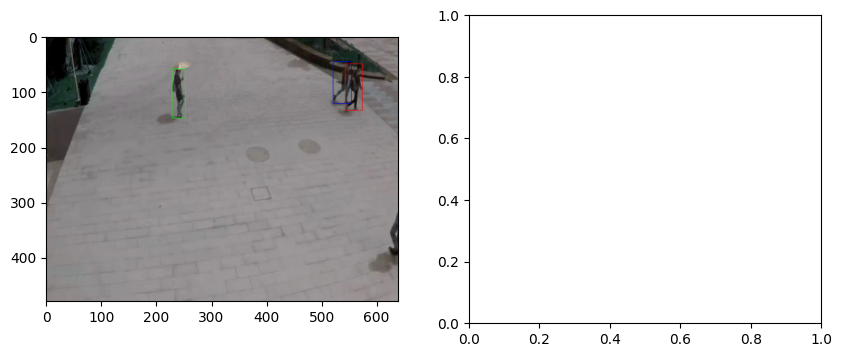

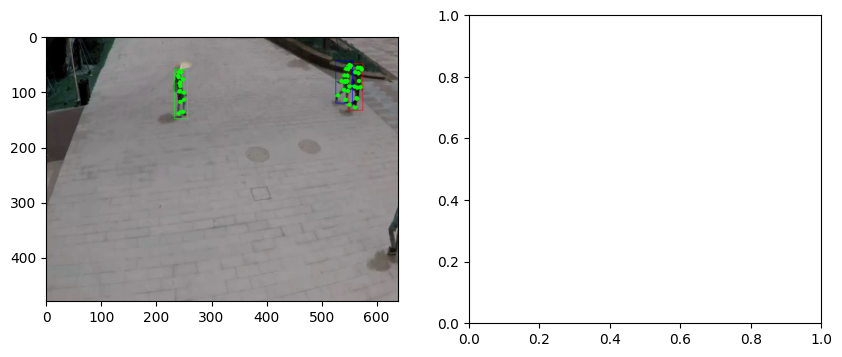

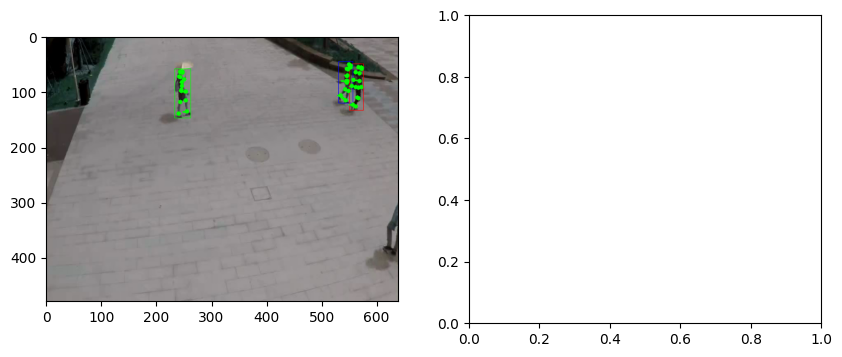

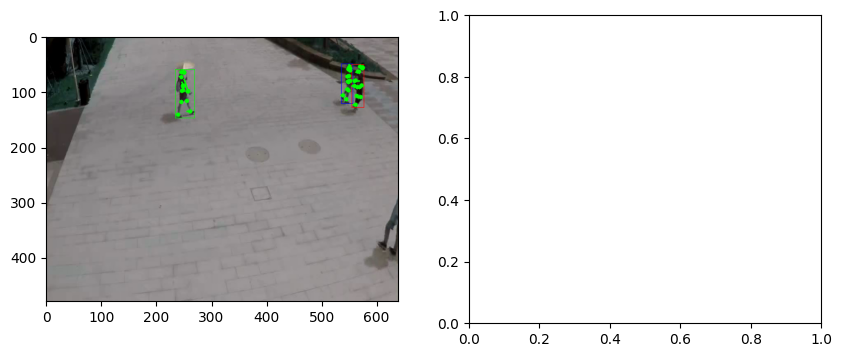

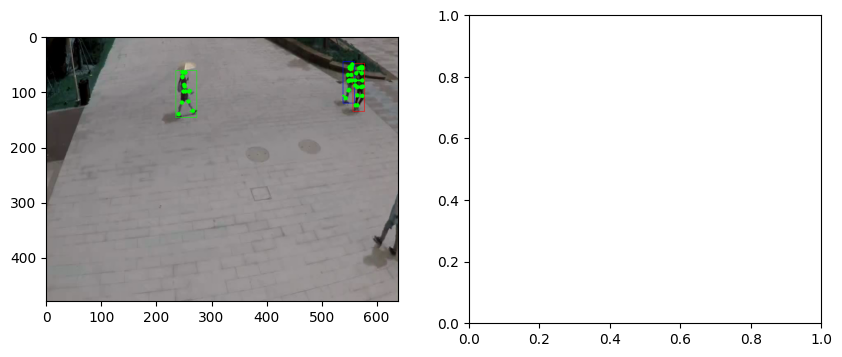

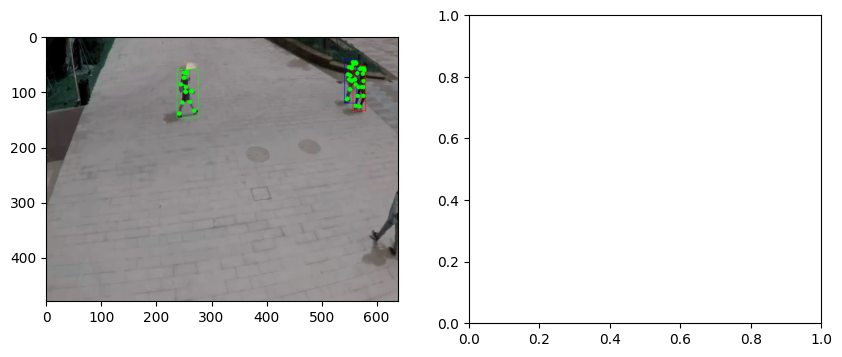

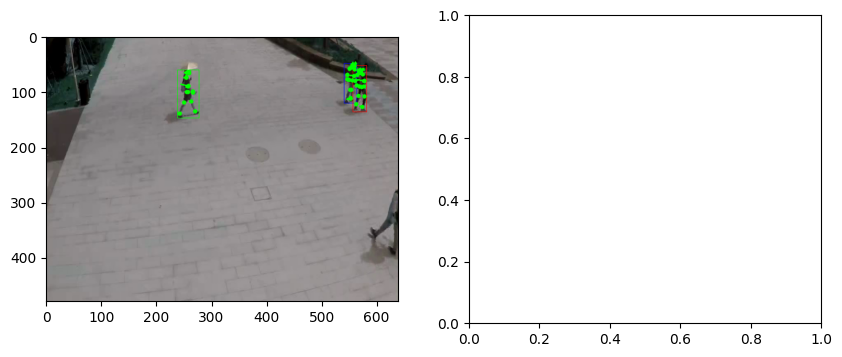

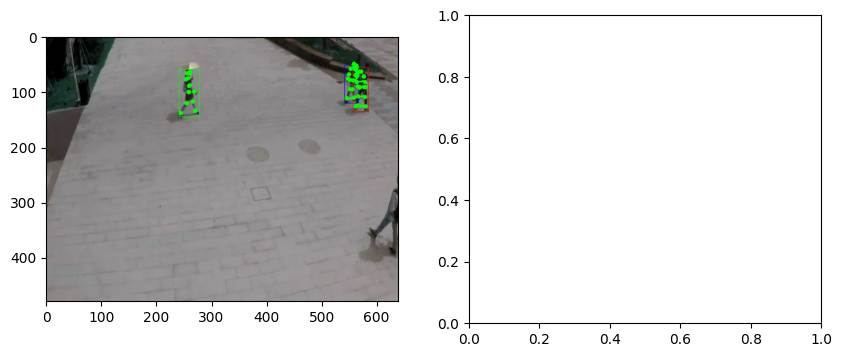

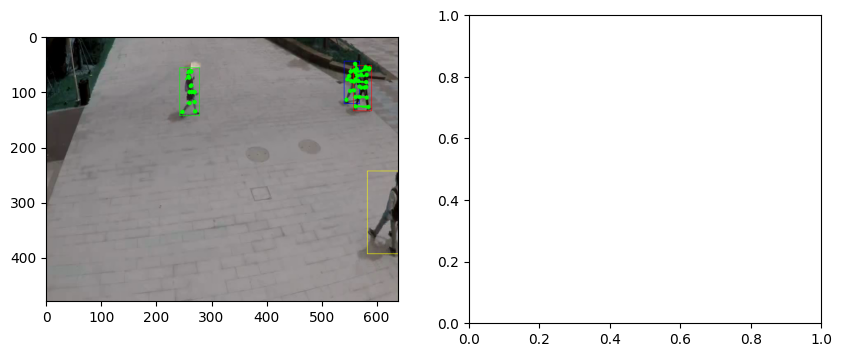

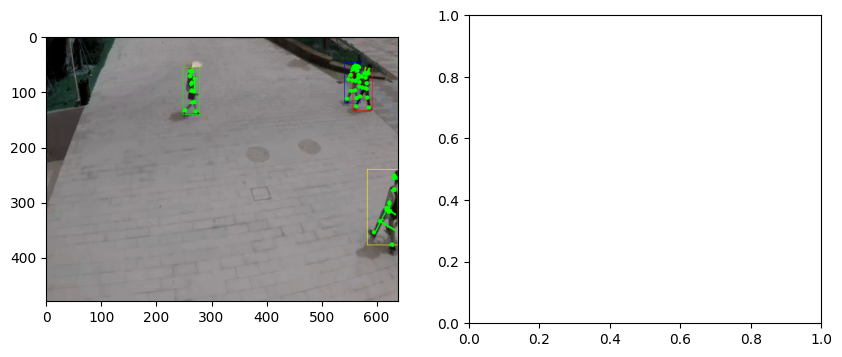

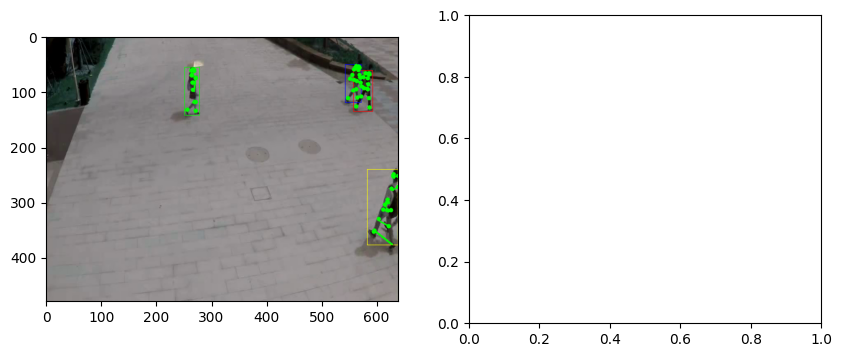

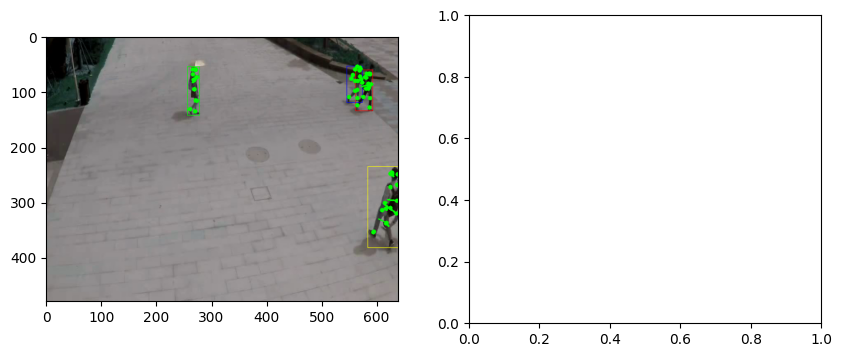

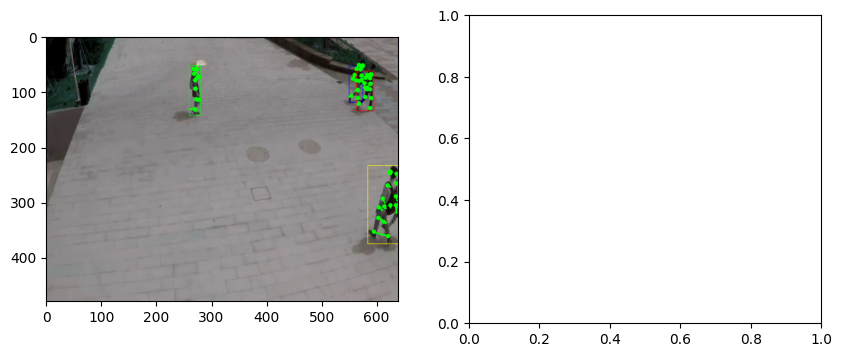

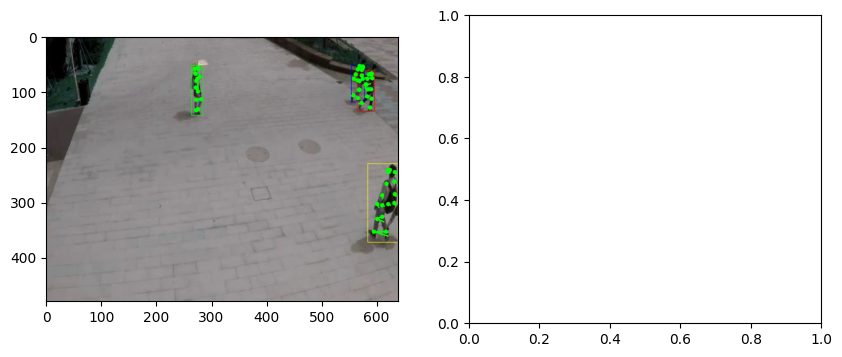

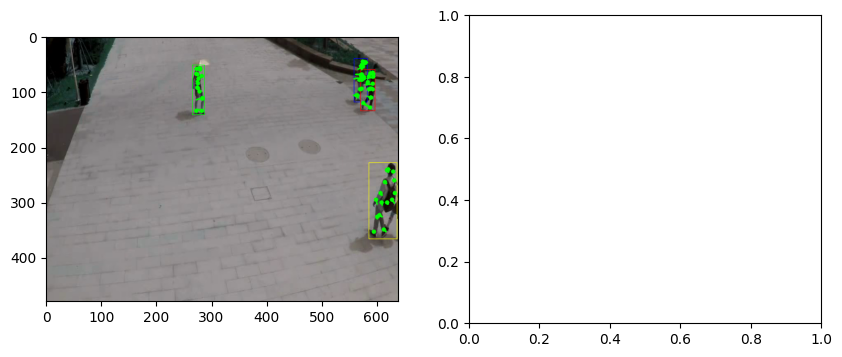

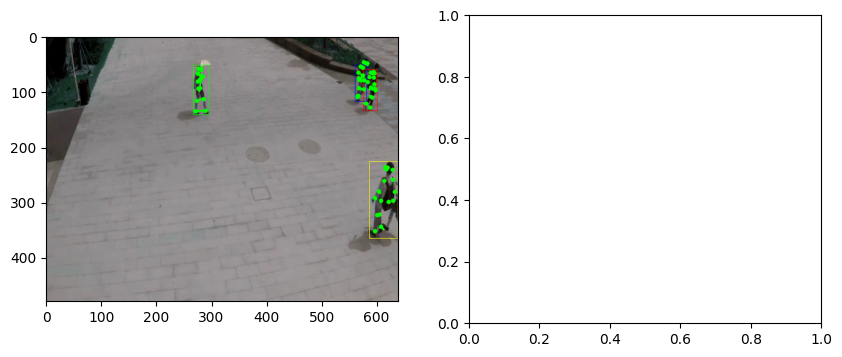

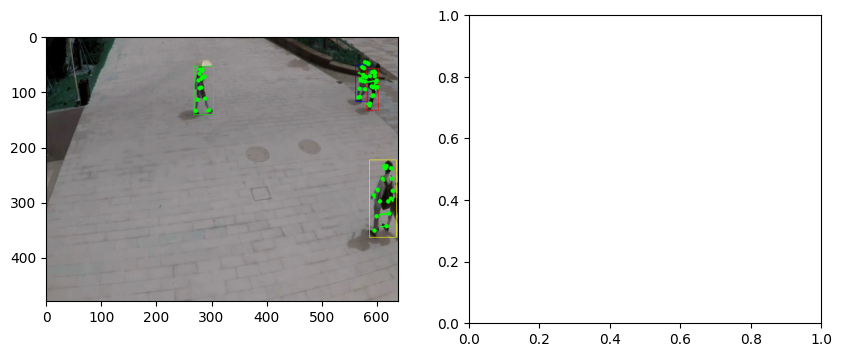

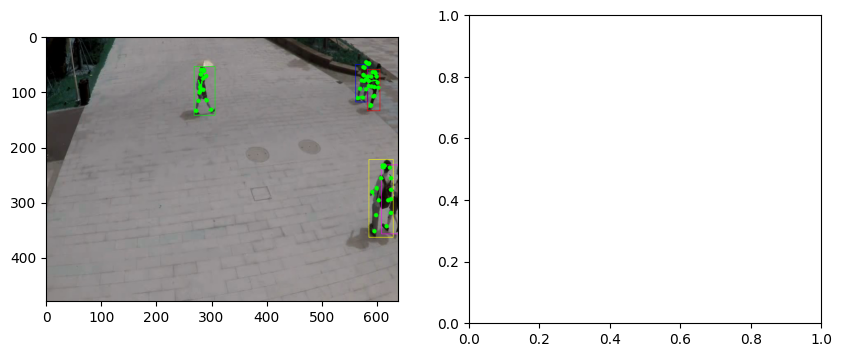

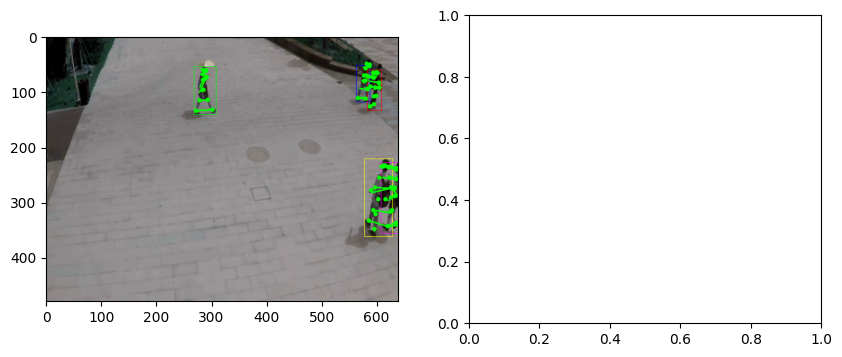

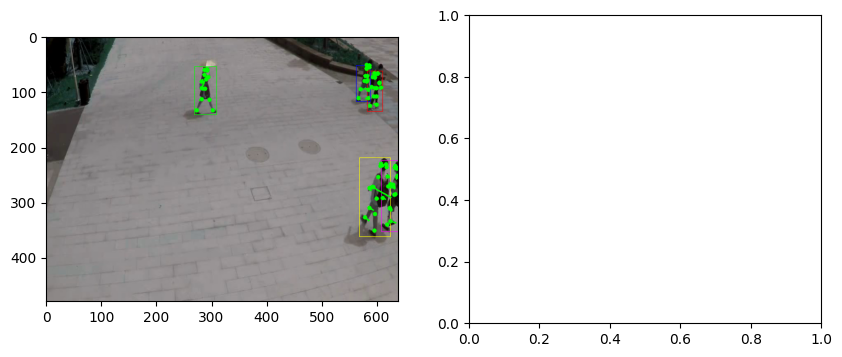

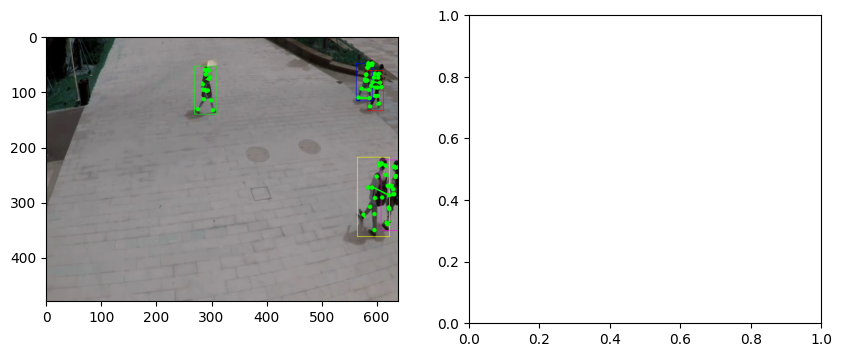

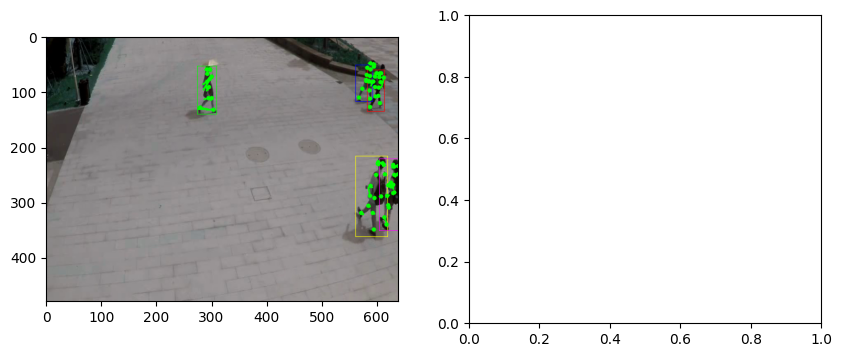

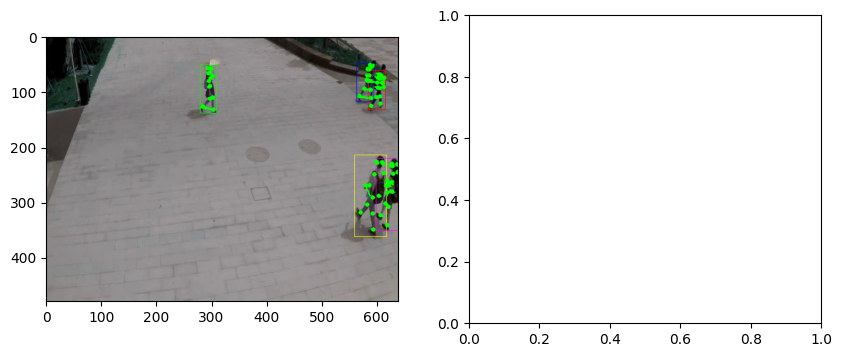

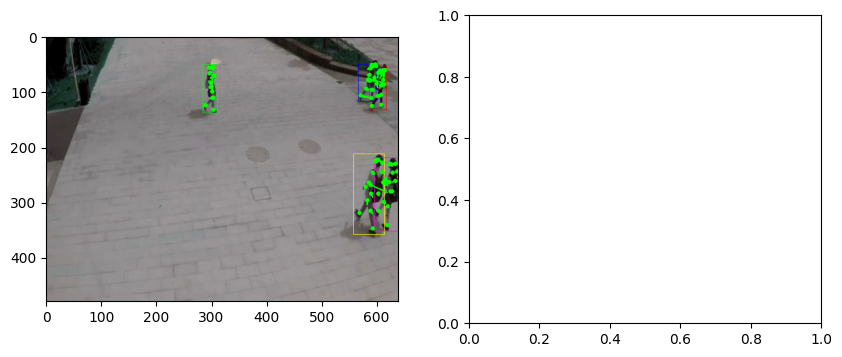

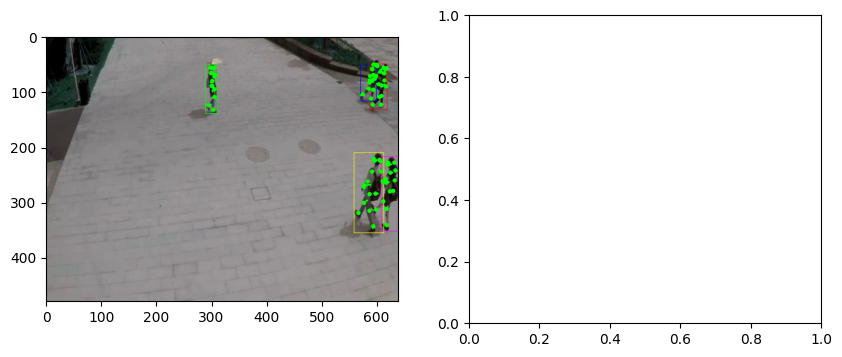

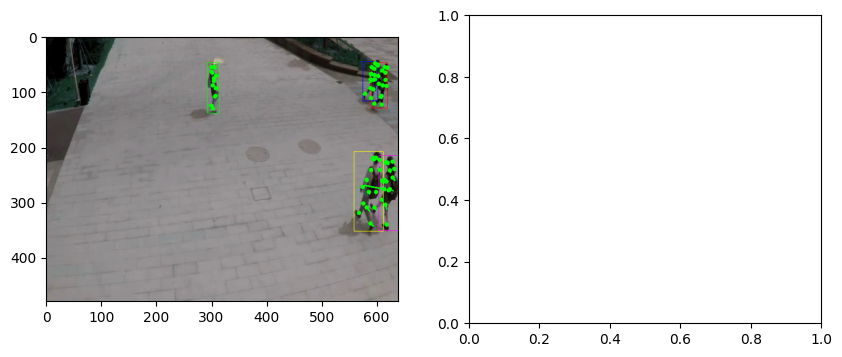

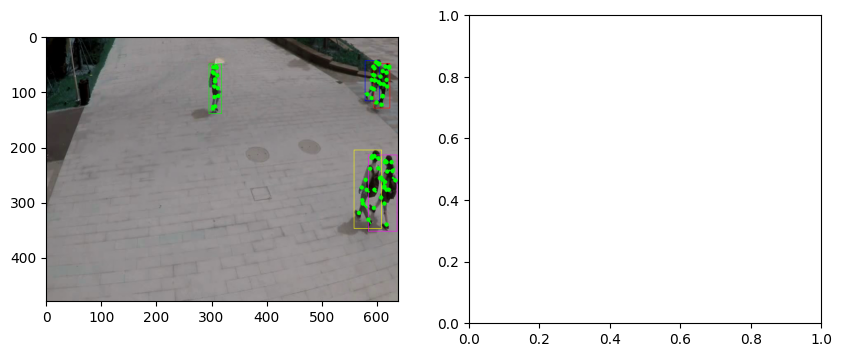

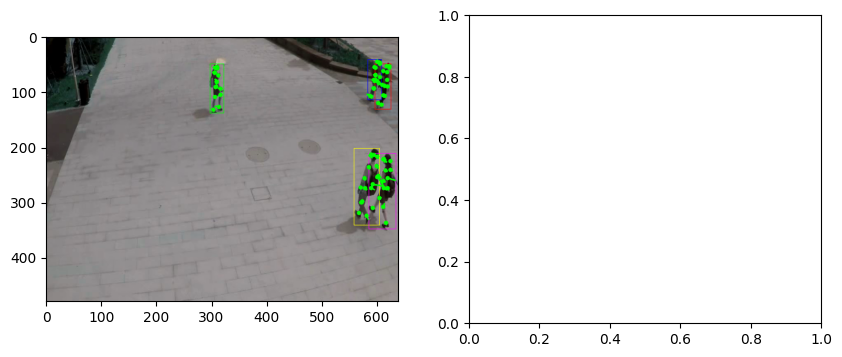

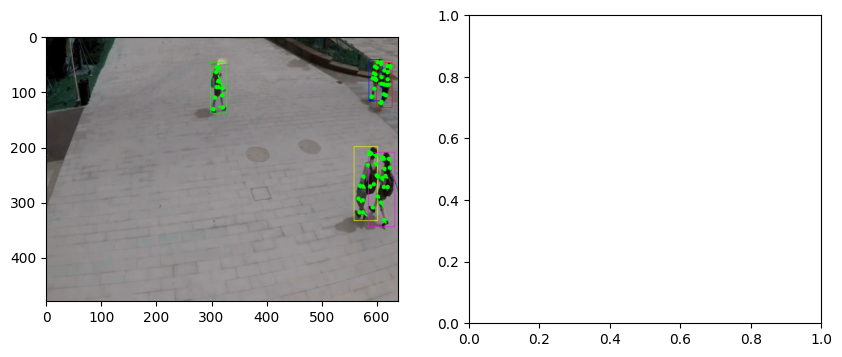

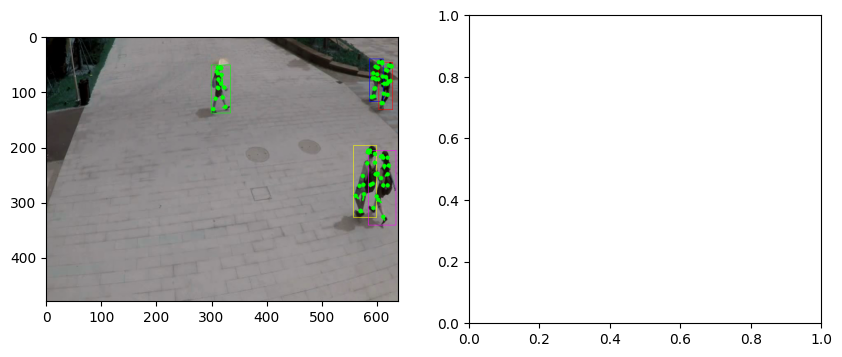

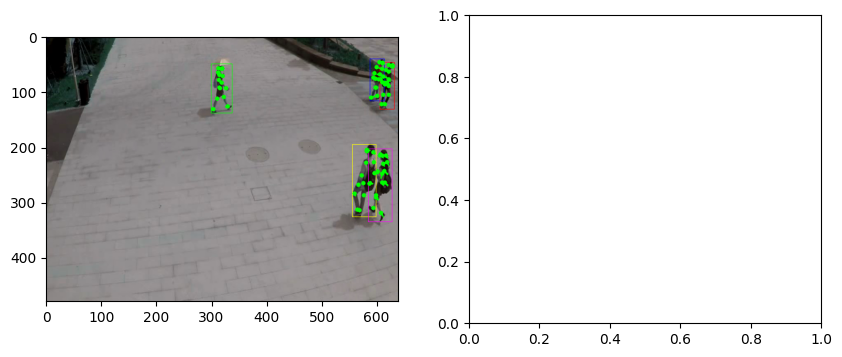

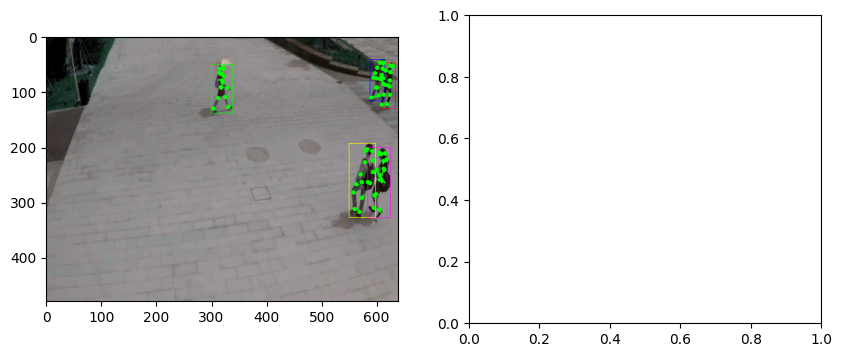

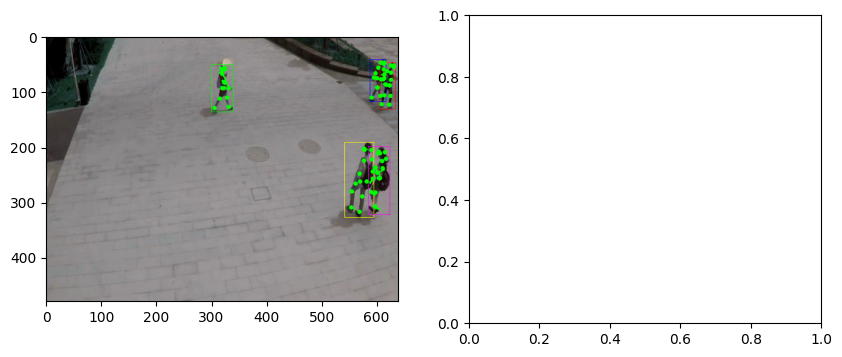

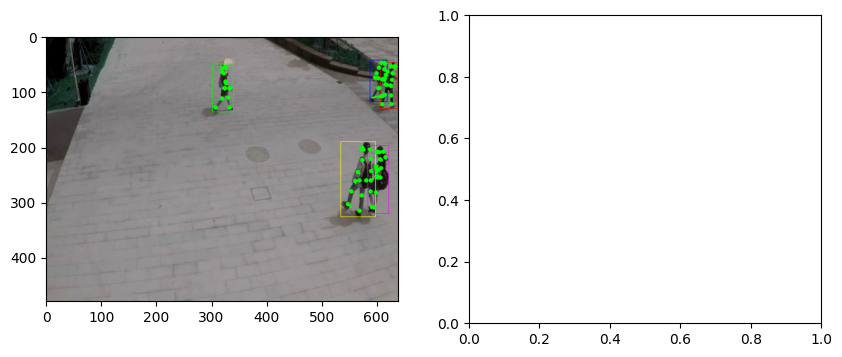

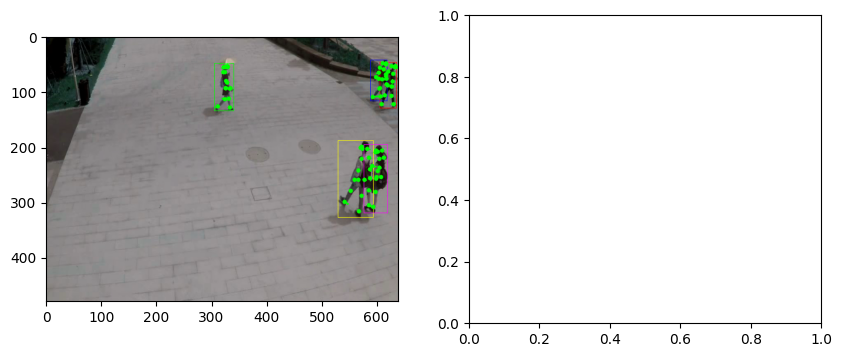

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import List, Dict, Tuple
from scipy.spatial import distance
import sys
sys.path.append('tapnet')

import torch
import torch.nn. functional as F
from tapnext_deploy import TapNextDeployer

sys.path.append('../pose-tracking/posedet_alpha')
from detector_alpha import DetectionLoader, PoseDet

%matplotlib inline
runner = TapNextDeployer(device="cuda", image_size=(256, 256))
runner.ensure_assets()
runner.load_model()
    
class CentroidTracker:
    """
    Minimal centroid-based multi-object tracker.
    Tracks objects by their bounding-box centroids and assigns unique IDs.
    """

    def __init__(self, pts_tracker, max_disappeared: int = 50, max_distance: float = 50.0) -> None:
        self.next_object_id: int = 0
        self.objects: Dict[int, Tuple[int, int]] = {}
        self.grid_pts: Dict = {}
        self.disappeared: Dict[int, int] = {}
        self.max_disappeared: int = max_disappeared
        self.max_distance: float = max_distance

        self.f_pts   = 10
        self.max_pts = self.f_pts **2
        self.max_iid = 25 
        self.logs = np.zeros((self.max_iid,self.max_pts+2,2)) # instance,
        self.pts_tracker = pts_tracker
        
    def register(self, frame, box: Tuple[float, float, float, float]) -> None:
        self.objects[self.next_object_id] = box
        self.grid_pts[self.next_object_id] = self.get_grid_pts(frame, box[0], box[1], box[2], box[3])
        self.disappeared[self.next_object_id] = 0
        self.next_object_id += 1

    def deregister(self, object_id: int) -> None:
        del self.objects[object_id]
        del self.grid_pts[object_id]
        del self.disappeared[object_id]

    def box2cnts(self, rects):
        centroids: List[Tuple[int, int]] = [
            (int(x + w / 2), int(y + h / 2)) for (x, y, w, h) in rects
        ]
        centroids = np.array(centroids)
        return centroids
    
    def get_grid_pts_old(self, x, y, w, h):
        mgd = np.meshgrid(np.linspace(x,x+w, self.f_pts, dtype = np.float32), np.linspace(y,y+h, self.f_pts, dtype = np.float32))
        curr_pts = np.stack(mgd).T.reshape(-1,2).astype(np.float32)
        return curr_pts
    
    def get_grid_pts(self, frame, x, y, w, h):
        boxes = torch.tensor([[x,y,x+w,y+h]])
        scores   = torch.tensor([[1.0]])
        ids      = torch.tensor([[0.0]])
        curr_pts = pose_det.detect(frame, boxes, scores, ids, show = False)
        if not len(curr_pts):
            return self.get_grid_pts_old(x,y,w,h)
        return curr_pts[0]['keypoints'].astype(np.float32)
        
    def get_tracked_pts(self, frame, tracked_boxes):
        viz = frame.copy()
        pts = {}
        all_pts = []
        for iid in tracked_boxes.keys():
                [x, y, w, h] = tracked_boxes[iid]
                curr_pts = self.get_grid_pts(frame, x, y, w, h)
                self.logs[iid, :2] = np.array([[x, y], [x+w, y+w]])
                self.logs[iid, 2:] = curr_pts[:,0,:]
                pts[iid] = curr_pts
                all_pts.append(curr_pts)
                cv2.putText(viz, f'{iid}', [x, y - 20], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.rectangle(viz, (x, y), (x + w, y + h), (0, 0, 255), 2)
        all_pts = np.concatenate(all_pts, axis =0)
        return pts, all_pts, viz
        
    def update(self, frame, rects: List[Tuple[int, int, int, int]]) -> Dict[int, Tuple[int, int]]:
        # Convert bounding boxes to centroids
        # Register new objects if none are tracked
        if len(self.objects) == 0:
            for box in rects:
                self.register(frame, box)
            return self.objects, self.grid_pts

        # If no detections, mark existing objects as disappeared
        if len(rects) == 0:
            for object_id in list(self.disappeared.keys()):
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)
            return self.objects, self.grid_pts

        # Build distance matrix between existing object centroids and new centroids
        object_ids = list(self.objects.keys())
        object_centroids = self.box2cnts(list(self.objects.values()))
        input_centroids  = self.box2cnts(rects)
        D = distance.cdist(object_centroids, input_centroids)

        # Match rows (existing objects) to columns (new detections) by distance
        rows = D.min(axis=1).argsort()
        cols = D.argmin(axis=1)[rows]

        used_rows = set()
        used_cols = set()

        for (row, col) in zip(rows, cols):
            if row in used_rows or col in used_cols:
                continue
            if D[row, col] > self.max_distance:
                continue
            object_id = object_ids[row]
            self.objects[object_id] = rects[col]
            self.disappeared[object_id] = 0
            used_rows.add(row)
            used_cols.add(col)

        # Unmatched rows: increment disappeared counters
        unused_rows = set(range(0, D.shape[0])).difference(used_rows)
        for row in unused_rows:
            object_id = object_ids[row]
            self.disappeared[object_id] += 1
            if self.disappeared[object_id] > self.max_disappeared:
                self.deregister(object_id)

        # Unmatched columns: register new objects
        unused_cols = set(range(0, D.shape[1])).difference(used_cols)
        for col in unused_cols:
            self.register(frame, rects[col])

        return self.objects, self.grid_pts

    def track_grid_pts(self, frame1, frame2):
        p1 = []
        for iid in sorted(self.grid_pts.keys()):
            x,y,w,h = self.objects[iid]
            self.grid_pts[iid] = self.get_grid_pts(frame2,x,y,w,h)
            #p0 = self.grid_pts[iid]
            #self.grid_pts[iid] = self.pts_tracker.track(frame1,frame2,p0)
            p1.append(self.grid_pts[iid])
        if not len(p1):
            return np.array([])
        return np.concatenate(p1, axis=0)

    def init_grid_pts(self):
        p0 = []
        for iid in sorted(self.grid_pts.keys()):
            p0.append(self.grid_pts[iid])
        if not len(p0):
            return np.array([])
        return np.concatenate(p0, axis=0)
        
    def save_logs(self, filename):
        np.save(filename, self.logs)
    
class MovingBoxes:
    def __init__(self):
        self.fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))

    def detect(self, frame):
        fgmask = self.fgbg.apply(frame.copy())
        fgmask = np.uint8(fgmask>200)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_DILATE, self.kernel, iterations=2)
        contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        curr_boxes = []  # List of bounding boxes
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            x = max(x,0)
            y = max(y,0)
            if min(w,h) > 25:#500:  # Filter out small noise
                curr_boxes.append((x, y, w, h))
        return np.array(curr_boxes, dtype=np.int32), fgmask

class FlowPtsTracker:
    def __init__(self):
        # Parameters for Lucas-Kanade Optical Flow
        self.lk_params = dict(winSize=(15, 15),
                         maxLevel=2,
                         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    def track(self, frame1, frame2, p0):
        # Calculate optical flow (track keypoints)
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
        p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0.reshape(1,-1,2), None, **self.lk_params)
        return p1.reshape(-1,2)
        
# Video source: 0 for webcam or path to video file
cap = cv2.VideoCapture(f'/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/videos/01_002.avi')

# Parameters for Shi-Tomasi corner detection (good features)
feature_params = dict(maxCorners=100,
                      qualityLevel=0.1, #0.3
                      minDistance=3, #7
                      blockSize=3) # 7

# Colors for drawing tracked keypoints
color = (0, 255, 0)

# Variables for tracking
old_frame = None
p0 = None  # Previous keypoints
ind = 0
first_frame = True

traj = []
pbar = tqdm(total =0, position =0)
kpts = []

def get_locotracker(frame, pts):
    from locotrack import load_model, CKPT, OnlineLocoTracker

    PREVIEW_WIDTH = 768       # draw/output width
    INPUT_HW = (256, 256)     # model input (H, W); keep default
    BUFFER_T = 32             # window size (temporal context)
    UPDATE_STRIDE = 1         # run model every N frames (1 = every frame)
    DRAW_TRAIL = True
    SAVE_MP4 = False          # set True to record an mp4 in ./outputs

    torch.backends.cudnn.benchmark = True
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32
    
    model = load_model(CKPT, model_size='small').to(device)
    
    tracker = OnlineLocoTracker(model, device=device, dtype=dtype,
                                buffer_T=BUFFER_T, input_hw=INPUT_HW,
                                preview_wh=(PREVIEW_WIDTH, None))

    # push first frame, then add points at t=0
    canvas = tracker.step(frame, run_model=False)
    tracker.add_points_at_current(pts)
    return tracker
        
#box_det     = MovingBoxes()
box_det     = DetectionLoader()
pose_det    = PoseDet()
pts_tracker = FlowPtsTracker() 
box_tracker = CentroidTracker(pts_tracker)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

def swap_xy(pt):
    x = pt[:,0].copy()
    y = pt[:,1].copy()
    pt[:,0] = y
    pt[:,1] = x
    return pt
colors = [[0,0,255],[0,255,0],[255,0,0],[255,255,0],[255,0,255],[0,0,2555],[0,0,0]]
while True:
    pbar.set_description(f"Step {ind}")
    pbar.update(1)
    ret, frame = cap.read()
    #temp = np.zeros((max_iid,max_pts+2,2)) # instance, bbox[4]:pts[100], [x, y]
    if not ret:
        break

    frame = cv2.resize(frame, (640, 480))
    viz   = frame.copy()
    gray  = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply background subtraction
    
    if first_frame:
        first_frame = False
        continue
        
    
    #curr_boxes, fgmask = box_det.detect(frame)
    img   = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pred_boxes, scores, ids = box_det.process(img)
    curr_boxes = []
    for ii, [box, scr] in enumerate(zip(pred_boxes, scores)):
        if scr>= 0.80:
            box[2:] = box[2:] - box[:2]
            curr_boxes.append(box)
        
    tracked_boxes, _   = box_tracker.update(frame, curr_boxes)
    
    for iid in tracked_boxes.keys():
        box = tracked_boxes[iid]
        #box[2:] = box[2:] - box[:2]
        #curr_boxes[ii]=box
        box = box.numpy().astype(np.int32)
        cv2.rectangle(viz, box[:2],box[:2]+box[2:],colors[iid%len(colors)],1,1)
    # Track keypoints
    if old_frame is None:
        old_frame  = frame
        p0 = box_tracker.init_grid_pts()
        #pts_tracker  = get_locotracker(f0, list(pts.reshape(-1,2)))
        #runner.track_step(f0, swap_xy(p0.reshape(-1,2)).copy(), mode = 'init')
    else:
        
        #f0 = cv2.cvtColor(old_frame, cv2.COLOR_BGR2RGB)
        #f1 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Track to next frame
        #p1 = swap_xy(runner.track_step(f1))
        p1 = box_tracker.track_grid_pts(old_frame, frame)
        
        good_old = []
        good_new = []
                
        if p1 is not None:
            # Select good points
            good_new = p1#[st == 1]
            good_old = p0#[st == 1]
            
            # Draw tracks 
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                cv2.line(viz, (int(a), int(b)), (int(c), int(d)), color, 2)
                cv2.circle(viz, (int(a), int(b)), 4, color, -1)
            
            # Update previous keypoints
            p0  = p1.reshape(-1, 2)
        old_frame = frame.copy()
        #runner.track_step(f1, p1.reshape(-1,2).copy(), mode = 'init')
        #kpts.append(temp)
        # Show results
    #import pdb; pdb.set_trace()
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes[0].imshow(viz)
    #axes[1].imshow(fgmask)
    #if old_frame is not None:
    #    canvas = pts_tracker.step(frame, run_model=True)
    #    axes[1].imshow(canvas)
    ind += 1
    if ind>=35:
        break
        #key = cv2.waitKey(30) & 0xFF
        #if key == 27:  # Press 'ESC' to exit
        #    break

cap.release()
cv2.destroyAllWindows()

In [2]:
scores

tensor([[0.9846],
        [0.9786],
        [0.9775],
        [0.9808],
        [0.9265],
        [0.1357]])

In [2]:
import cv2
import sys
sys.path.append('../pose-tracking/posedet_alpha')
from detector_alpha import DetectionLoader, PoseDet
det_loader = DetectionLoader()
pose_det   = PoseDet()

cap = cv2.VideoCapture(f'/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/videos/01_002.avi')
while 1:
    _, img = cap.read()
    img   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, scores, ids = det_loader.process(img)#.read()
    pose   = pose_det.detect(img, boxes, scores, ids, show=False)
    break

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pose model from ../models/pose/alpha_pose/fast_res50_256x192.pth...
Loading YOLOX-X model..


/projects/Deep-Learning-For-Computer-Vision-org/keypoint_tracking/../pose-tracking/posedet_alpha/detector_alpha.py:299: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  inps = torch.tensor(inps)


In [3]:
pose[]

[{'keypoints': array([[759,  60],
         [759,  58],
         [759,  58],
         [752,  57],
         [756,  57],
         [746,  65],
         [753,  68],
         [740,  75],
         [755,  82],
         [735,  87],
         [761,  91],
         [745,  92],
         [750,  94],
         [750, 111],
         [746, 113],
         [750, 128],
         [728, 124]], dtype=int32),
  'kp_score': array([[0.8887401 ],
         [0.8354159 ],
         [0.8568356 ],
         [0.7648447 ],
         [0.824047  ],
         [0.7894428 ],
         [0.76081014],
         [0.4384283 ],
         [0.7778218 ],
         [0.16549514],
         [0.84486455],
         [0.56648785],
         [0.74652475],
         [0.7946663 ],
         [0.7760584 ],
         [0.8224396 ],
         [0.6787636 ]], dtype=float32),
  'proposal_score': tensor([2.8263]),
  'idx': [0.0],
  'bbox': array([716.99728394,  43.19359398, 771.00424194, 143.82412529])},
 {'keypoints': array([[734,  54],
         [734,  52],
         [

In [10]:
img.shape, orig_img.shape

((480, 856, 3), (480, 856, 3))

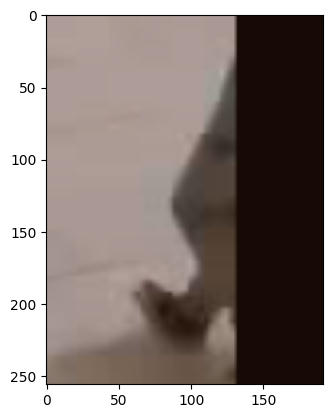

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(inps[3].permute(1,2,0)+0.5)
plt.show()

In [2]:
curr_boxes

array([], dtype=int32)

In [3]:
box[:2],box[2:]

((0, 0), (640, 480))

In [ ]:
runner._device

In [3]:
np.stack(p0, axis=0).shape

(300, 1, 2)

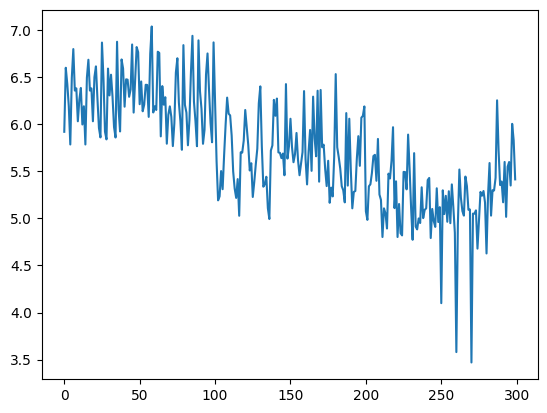

In [5]:
while rval:
  rval, frame = get_frame(vc)
  numpy_frame = frame
  if query_frame:
    query_points = np.array((0,) + pos, dtype=np.float32)
    frame = torch.tensor(frame).to(device)
    query_points = torch.tensor(query_points).to(device)

    init_query_features = online_model_init(
        frames=frame[None, None], points=query_points[None, None]
    )
    query_frame = False
    query_features, causal_state = model.update_query_features(
        query_features=query_features,
        new_query_features=init_query_features,
        idx_to_update=np.array([next_query_idx]),
        causal_state=causal_state,
    )
    have_point[next_query_idx] = True
    next_query_idx = (next_query_idx + 1) % NUM_POINTS
  if pos:
    frame = torch.tensor(frame).to(device)
    track, visible, causal_state = online_model_predict(
        frames=frame[None, None],
        features=query_features,
        causal_context=causal_state,
    )
    track = np.round(track.cpu().numpy())
    visible = visible.cpu().numpy()

    for i, _ in enumerate(have_point):
      if visible[0, i, 0] and have_point[i]:
        cv2.circle(
            numpy_frame,
            (int(track[0, i, 0, 0]), int(track[0, i, 0, 1])),
            5,
            (255, 0, 0),
            -1,
        )
        if track[0, i, 0, 0] < 16 and track[0, i, 0, 1] < 16:
          print((i, next_query_idx))
  cv2.imshow("Point Tracking", numpy_frame[:, ::-1])
  if pos:
    step_counter += 1
    if time.time() - t > 5:
      print(f"{step_counter/(time.time()-t)} frames per second")
      t = time.time()
      step_counter = 0
  else:
    t = time.time()
  key = cv2.waitKey(1)

  if key == 27:  # exit on ESC
    break

cv2.destroyWindow("Point Tracking")
vc.release()


In [13]:
p0

array([[[  9.       ,  82.       ]],

       [[  9.       ,  93.77778  ]],

       [[  9.       , 105.55556  ]],

       [[  9.       , 117.333336 ]],

       [[  9.       , 129.11111  ]],

       [[  9.       , 140.88889  ]],

       [[  9.       , 152.66667  ]],

       [[  9.       , 164.44444  ]],

       [[  9.       , 176.22223  ]],

       [[  9.       , 188.       ]],

       [[ 13.       ,  82.       ]],

       [[ 13.       ,  93.77778  ]],

       [[ 13.       , 105.55556  ]],

       [[ 13.       , 117.333336 ]],

       [[ 13.       , 129.11111  ]],

       [[ 13.       , 140.88889  ]],

       [[ 13.       , 152.66667  ]],

       [[ 13.       , 164.44444  ]],

       [[ 13.       , 176.22223  ]],

       [[ 13.       , 188.       ]],

       [[ 17.       ,  82.       ]],

       [[ 17.       ,  93.77778  ]],

       [[ 17.       , 105.55556  ]],

       [[ 17.       , 117.333336 ]],

       [[ 17.       , 129.11111  ]],

       [[ 17.       , 140.88889  ]],

       [[ 17

In [14]:
p1

array([[ 22.128952 , 153.40051  ],
       [ 22.218222 , 175.43103  ],
       [ 22.273798 , 197.8177   ],
       [ 22.184862 , 219.64583  ],
       [ 22.432116 , 241.70937  ],
       [ 22.562326 , 263.84674  ],
       [ 22.328053 , 285.9233   ],
       [ 22.325403 , 307.97165  ],
       [ 22.19919  , 330.1338   ],
       [ 22.20991  , 352.31085  ],
       [ 32.133247 , 153.37491  ],
       [ 32.278294 , 175.4285   ],
       [ 32.231277 , 197.85222  ],
       [ 32.32464  , 219.67673  ],
       [ 32.318924 , 241.6696   ],
       [ 32.227016 , 263.88544  ],
       [ 32.096947 , 285.95596  ],
       [ 32.360405 , 307.98407  ],
       [ 32.091022 , 330.0643   ],
       [ 32.17436  , 352.28275  ],
       [ 42.219616 , 153.34358  ],
       [ 42.357452 , 175.44011  ],
       [ 42.22895  , 197.80995  ],
       [ 42.318287 , 219.61029  ],
       [ 42.197502 , 241.65839  ],
       [ 42.42235  , 263.8471   ],
       [ 42.34904  , 285.92313  ],
       [ 42.41476  , 308.03802  ],
       [ 42.307735 ,

In [2]:
from torch.utils._pytree import register_dataclass

ImportError: cannot import name 'register_dataclass' from 'torch.utils._pytree' (/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py)

In [13]:
from tapnet.tapnext.tapnext_torch_utils import restore_model_from_jax_checkpoint as _restore_jax_ckpt

In [11]:
#pip install chex
#!pip install einshape
#!pip install dm-haiku
!pip install optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.3/354.3 KB 2.3 MB/s eta 0:00:0000:0100:01


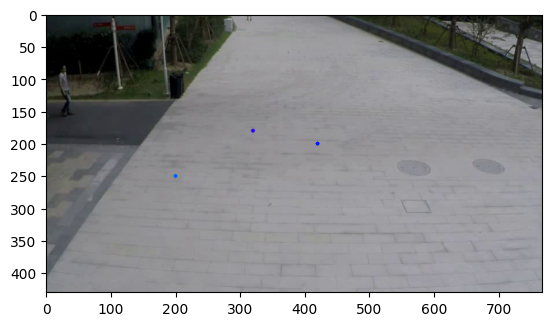

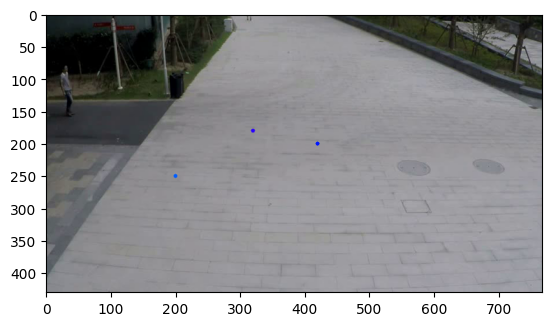

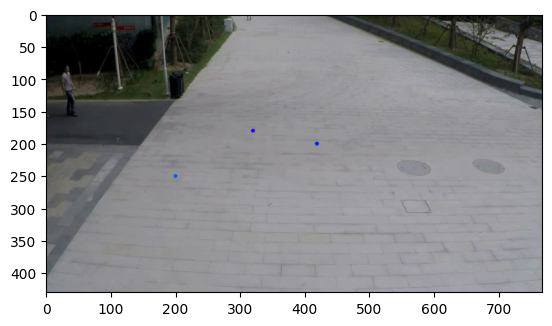

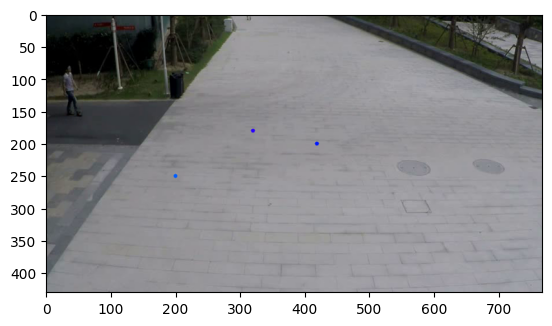

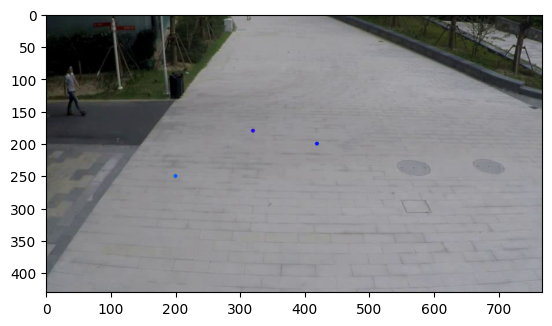

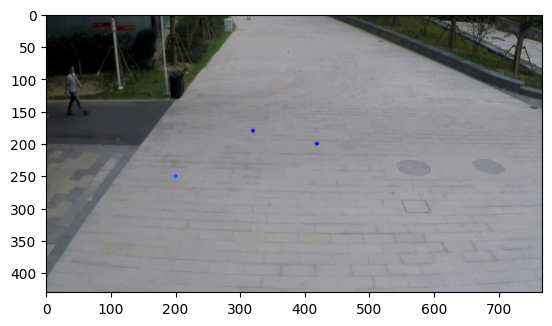

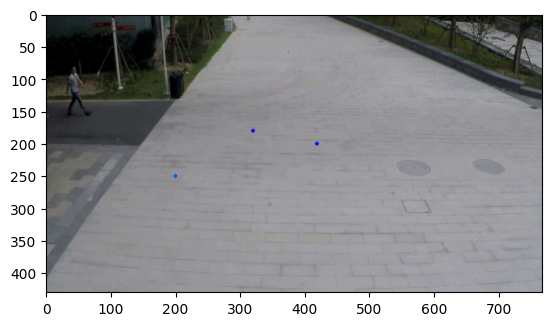

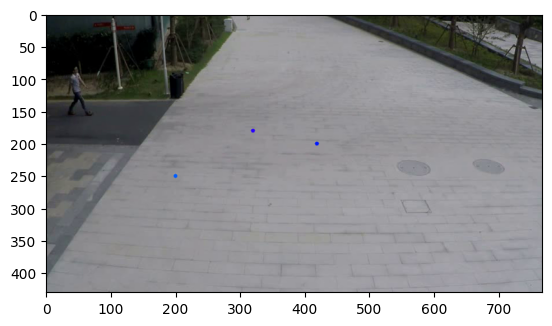

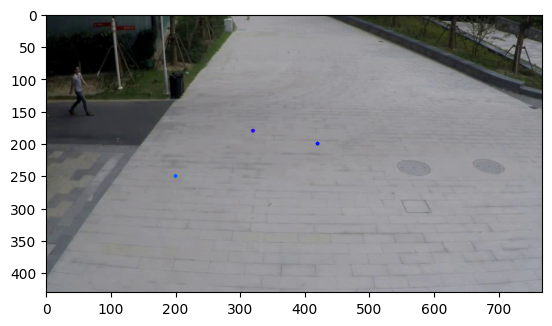

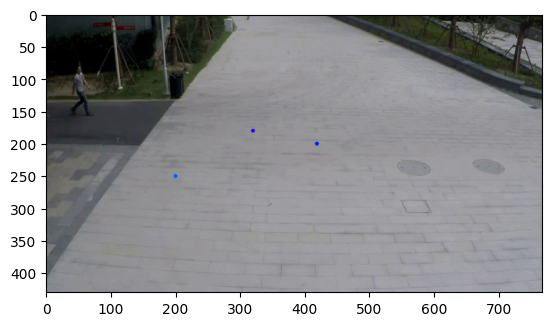

In [7]:
from matplotlib import pyplot as plt

def _draw_tracks(preview_video, tracks, colors=None, radius=3):
    """
    preview_video: (T, H, W, 3) uint8
    tracks: (N, T, 2) in preview pixel coords
    visible_mask: (N, T) booleans; True = visible
    colors: (N, 3) BGR uint8 or None
    """
    T, H, W = preview_video.shape[:3]
    out = preview_video.copy()
    N = tracks.shape[0]

    if colors is None:
        # simple color wheel
        import matplotlib
        cols = []
        for i in range(N):
            c = matplotlib.colormaps.get_cmap("gist_rainbow")((i % 20)/20)
            cols.append((int(c[2]*255), int(c[1]*255), int(c[0]*255)))  # BGR
        colors = cols

    for n in range(N):
        for t in range(T):
            #if not visible_mask[n, t]:
            #    continue
            x, y = tracks[n, t]
            x_i, y_i = int(round(x)), int(round(y))
            if 0 <= x_i < W and 0 <= y_i < H:
                cv2.circle(out[t], (x_i, y_i), radius, colors[n], -1)
    return out

ret = _draw_tracks(ret, tcr)
for i in range(10):
   plt.imshow(ret[i])
   plt.show()

In [1]:
%%writefile locotrack.py
import os
import cv2
import uuid
import time
import numpy as np
from pathlib import Path
import torch
from matplotlib import pyplot as plt

# --- Repo imports (same as the official demo) ---
import sys
import sys
sys.path.append("locotrack/locotrack_pytorch")
from models.locotrack_model import load_model, FeatureGrids  # repo API

# ===================== User knobs =====================
SOURCE = "0"              # "0" for webcam, or "/path/to/video.mp4"
MODEL_SIZE = "small"      # "small" or "base"
CVIDEO_PATH = "/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/videos/01_001.avi"               # <- change me
CKPT = f"./locotrack/weights/locotrack_small.ckpt"

PREVIEW_WIDTH = 768       # draw/output width
INPUT_HW = (256, 256)     # model input (H, W); keep default
BUFFER_T = 32             # window size (temporal context)
UPDATE_STRIDE = 1         # run model every N frames (1 = every frame)
DRAW_TRAIL = True
SAVE_MP4 = False          # set True to record an mp4 in ./outputs

# Hard-coded points (in PREVIEW pixels) to start tracking at FIRST frame
# e.g., [(x,y), (x,y), ...]
HARDCODED_POINTS = [(320, 180), (420, 200), (250, 300)]
# ======================================================

def _make_colors(n):
    # fixed color wheel (BGR)
    import math
    cols = []
    for i in range(n):
        a = i / max(1, n)
        b = int(127.5 * (1 + math.sin(2*np.pi*a)))
        g = int(127.5 * (1 + math.sin(2*np.pi*(a + 1/3))))
        r = int(127.5 * (1 + math.sin(2*np.pi*(a + 2/3))))
        cols.append((b, g, r))
    return cols

class OnlineLocoTracker:
    def __init__(self, model, device="cuda", dtype=torch.bfloat16,
                 buffer_T=32, input_hw=(256,256), preview_wh=(768, None)):
        self.model = model.eval()
        self.device = device
        self.dtype = dtype
        self.buffer_T = buffer_T
        self.in_h, self.in_w = input_hw
        self.prev_w, self.prev_h = preview_wh  # prev_h resolved after first frame

        # rolling buffers
        self.buf_input = []   # list of (H,W,3) uint8 resized to input
        self.buf_preview = [] # list of (H,W,3) uint8 resized to PREVIEW
        self.frame_count = 0

        # per-point state
        self.points = []      # list of dicts: {'anchor_t': int, 'x_m': float, 'y_m': float, 'color': (b,g,r)}
        self.history = []     # list of list of (x_prev, y_prev, visible_bool)

        self.colors = []

    def _resize_frames(self, frame_bgr):
        H, W = frame_bgr.shape[:2]
        if self.prev_h is None:
            self.prev_h = int(self.prev_w * H / W)
        preview_frame = cv2.resize(frame_bgr, (self.prev_w, self.prev_h), interpolation=cv2.INTER_AREA)
        input_frame   = cv2.resize(frame_bgr, (self.in_w, self.in_h), interpolation=cv2.INTER_AREA)
        return preview_frame, input_frame

    def add_points_at_current(self, pts_preview):
        # called at t = last frame in buffer
        if not pts_preview:
            return
        if not self.colors:
            self.colors = _make_colors(max(3, len(pts_preview)))

        sx = self.in_w / self.prev_w
        sy = self.in_h / self.prev_h
        t_anchor = len(self.buf_input) - 1  # last frame in buffer

        for i, (x, y) in enumerate(pts_preview):
            self.points.append({
                'anchor_t': t_anchor,
                'x_m': float(x * sx),
                'y_m': float(y * sy),
                'color': self.colors[(len(self.points)+i) % len(self.colors)],
            })
            self.history.append([])

    def _maybe_pop_front(self):
        popped = False
        if len(self.buf_input) > self.buffer_T:
            self.buf_input.pop(0)
            self.buf_preview.pop(0)
            popped = True
            # shift anchor_t for all points
            for p in self.points:
                p['anchor_t'] -= 1
        return popped

    @torch.inference_mode()
    def _run_model(self):
        # Build FeatureGrids as in the demo (normalize to [-1,1], last-level grids)
        vid_np = np.stack(self.buf_input, axis=0)  # (T,H,W,3) uint8
        x = (vid_np / 255.0) * 2 - 1
        x = torch.tensor(x).unsqueeze(0).to(self.device, dtype=self.dtype)  # (1,T,H,W,3)

        # no autocast on CPU
        if self.device == "cuda":
            autocast_ctx = torch.autocast(device_type="cuda", dtype=self.dtype)
        else:
            from contextlib import nullcontext
            autocast_ctx = nullcontext()

        with autocast_ctx:
            feats = self.model.get_feature_grids(x)
        feats = FeatureGrids(
            lowres=(feats.lowres[-1].to(self.device, self.dtype),),
            hires=(feats.hires[-1].to(self.device, self.dtype),),
            highest=(feats.highest[-1].to(self.device, self.dtype),),
            resolutions=(feats.resolutions[-1],),
        )

        # Build query tensor from anchors (flip xyt->tyx like the demo)
        if not self.points:
            return None

        q = []
        for p in self.points:
            q.append([p['x_m'], p['y_m'], p['anchor_t']])  # x,y,t
        q = torch.tensor(q, dtype=torch.float32)[None].flip(-1).to(self.device, self.dtype)  # (1,N,3) tyx

        with autocast_ctx:
            out = self.model(x, q, feature_grids=feats)

        # tracks: (N, T, 2) in model coordinates
        tracks = out['tracks'][0].float().cpu().numpy()
        # occlusion -> visible mask; combine with expected_dist like demo
        occ = torch.sigmoid(out['occlusion'])
        if 'expected_dist' in out:
            ed = torch.sigmoid(out['expected_dist'])
            occ = 1 - (1 - occ) * (1 - ed)
        visible = (occ[0].cpu().numpy() <= 0.5)  # True = visible

        return tracks, visible

    def step(self, frame_bgr, run_model=True):
        # 1) add resized frames to buffers
        prev, inp = self._resize_frames(frame_bgr)
        self.buf_preview.append(prev)
        self.buf_input.append(inp)
        self.frame_count += 1

        # 2) drop oldest and adjust anchors
        dropped = self._maybe_pop_front()

        # 3) if any anchor got dropped (anchor_t < 0), re-anchor that point to last known pred
        #    (we do this AFTER a model run when we have a last prediction; on the very first drop
        #     we just clamp to t = last frame and keep xy as-is until next run)
        for p in self.points:
            if p['anchor_t'] < 0:
                p['anchor_t'] = len(self.buf_input) - 1  # re-anchor at current last frame

        # 4) run model (optionally)
        tracks, visible = (None, None)
        if run_model and self.points:
            res = self._run_model()
            if res is not None:
                tracks, visible = res
                # update each point’s last position (model coords) and append to history
                T = tracks.shape[1]
                for i, p in enumerate(self.points):
                    x_m, y_m = tracks[i, T-1]
                    p['x_m'], p['y_m'] = float(x_m), float(y_m)

                    # to preview coords
                    x_p = x_m * (self.prev_w / self.in_w)
                    y_p = y_m * (self.prev_h / self.in_h)
                    vis = bool(visible[i, T-1])
                    self.history[i].append((float(x_p), float(y_p), vis))

                    # if anchor_t got negative earlier, ensure it sits at last frame after update
                    if p['anchor_t'] < 0:
                        p['anchor_t'] = T - 1

        # 5) draw current frame
        canvas = prev.copy()
        for i, p in enumerate(self.points):
            # Draw last observation if available, else draw anchor
            if self.history[i]:
                x_p, y_p, vis = self.history[i][-1]
                if vis:
                    cv2.circle(canvas, (int(round(x_p)), int(round(y_p))), 4, p['color'], -1, lineType=cv2.LINE_AA)
            else:
                # draw the anchor location
                x_p = p['x_m'] * (self.prev_w / self.in_w)
                y_p = p['y_m'] * (self.prev_h / self.in_h)
                cv2.circle(canvas, (int(round(x_p)), int(round(y_p))), 4, p['color'], -1, lineType=cv2.LINE_AA)

            # Optional trail
            if DRAW_TRAIL and len(self.history[i]) >= 2:
                pts = [(int(round(x)), int(round(y))) for (x, y, v) in self.history[i] if v]
                for a, b in zip(pts[:-1], pts[1:]):
                    cv2.line(canvas, a, b, p['color'], 2, lineType=cv2.LINE_AA)

        return canvas

def main():
    assert Path(CKPT).exists(), f"Checkpoint not found at {CKPT}"
    torch.backends.cudnn.benchmark = True

    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32

    model = load_model(CKPT, model_size=MODEL_SIZE).to(device)

    # open source
    if CVIDEO_PATH == "0":
        cap = cv2.VideoCapture(0)
    else:
        cap = cv2.VideoCapture(CVIDEO_PATH)

    if not cap.isOpened():
        raise RuntimeError(f"Failed to open source: {SOURCE}")

    # Resolve preview height from first frame
    ok, frame = cap.read()
    if not ok:
        raise RuntimeError("No frames available from source.")
    tracker = OnlineLocoTracker(model, device=device, dtype=dtype,
                                buffer_T=BUFFER_T, input_hw=INPUT_HW,
                                preview_wh=(PREVIEW_WIDTH, None))

    # push first frame, then add points at t=0
    canvas = tracker.step(frame, run_model=False)
    tracker.add_points_at_current(HARDCODED_POINTS)

    # writer
    writer = None
    if SAVE_MP4:
        Path("outputs").mkdir(parents=True, exist_ok=True)
        out_path = f"outputs/locotrack_stream_{uuid.uuid4().hex}.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(out_path, fourcc, 30, (canvas.shape[1], canvas.shape[0]))

    # Display loop
    frame_idx = 1
    last_t = time.time()
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        run_now = (frame_idx % UPDATE_STRIDE == 0)
        canvas = tracker.step(frame, run_model=run_now)

        # FPS text
        now = time.time()
        fps = 1.0 / max(1e-6, now - last_t)
        last_t = now
        cv2.putText(canvas, f"FPS: {fps:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (40, 200, 40), 2, cv2.LINE_AA)

        if writer is not None:
            writer.write(canvas)

        #cv2.imshow("LocoTrack (Online)", canvas)
        #key = cv2.waitKey(1) & 0xFF
        #if key == 27 or key == ord('q'):
        #    break
        plt.imshow(canvas)
        plt.show()
        frame_idx += 1

    #cap.release()
    if writer is not None:
        writer.release()
        print(f"Saved: {out_path}")
    #cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


Overwriting locotrack.py


In [5]:
preview_video.shape

NameError: name 'preview_video' is not defined

In [7]:
feats1['descriptors'].detach().cpu().numpy().shape

(1, 2048, 256)

In [4]:
good_old.shape

torch.Size([1, 8, 2])

In [5]:
pp0 = p0.reshape(-1,2)

tensor([[[ 0.0194, -0.0015, -0.0148,  ..., -0.0363, -0.0324, -0.0285],
         [-0.0397, -0.0203, -0.0019,  ..., -0.0523, -0.0463, -0.0438],
         [-0.0161,  0.0239,  0.0569,  ...,  0.0013,  0.0025,  0.0028],
         ...,
         [ 0.0388,  0.0025, -0.0194,  ..., -0.0101, -0.0050, -0.0010],
         [ 0.0289,  0.0045, -0.0130,  ..., -0.0223, -0.0162, -0.0140],
         [ 0.0422,  0.0601,  0.0606,  ..., -0.0009,  0.0004, -0.0004]]])

In [5]:
pts

array([[[ 16.       ,  83.       ]],

       [[ 16.       ,  94.333336 ]],

       [[ 16.       , 105.666664 ]],

       [[ 16.       , 117.       ]],

       [[ 16.       , 128.33333  ]],

       [[ 16.       , 139.66667  ]],

       [[ 16.       , 151.       ]],

       [[ 16.       , 162.33333  ]],

       [[ 16.       , 173.66667  ]],

       [[ 16.       , 185.       ]],

       [[ 21.555555 ,  83.       ]],

       [[ 21.555555 ,  94.333336 ]],

       [[ 21.555555 , 105.666664 ]],

       [[ 21.555555 , 117.       ]],

       [[ 21.555555 , 128.33333  ]],

       [[ 21.555555 , 139.66667  ]],

       [[ 21.555555 , 151.       ]],

       [[ 21.555555 , 162.33333  ]],

       [[ 21.555555 , 173.66667  ]],

       [[ 21.555555 , 185.       ]],

       [[ 27.11111  ,  83.       ]],

       [[ 27.11111  ,  94.333336 ]],

       [[ 27.11111  , 105.666664 ]],

       [[ 27.11111  , 117.       ]],

       [[ 27.11111  , 128.33333  ]],

       [[ 27.11111  , 139.66667  ]],

       [[ 27

In [9]:
from PIL import Image
pil = Image.fromarray(gray).convert("RGB")
res = matcher.preprocess(pil)

In [4]:
p1 = matcher.track_points(old_gray, gray, p0.reshape(-1,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


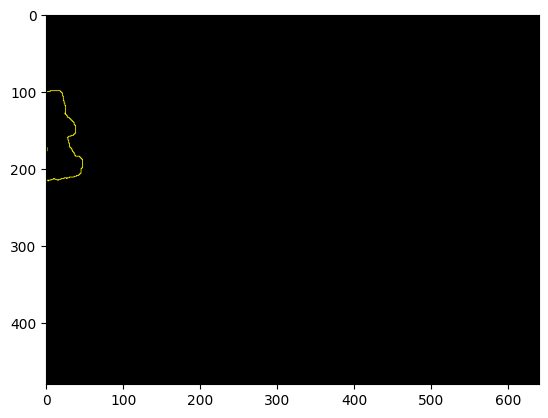

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


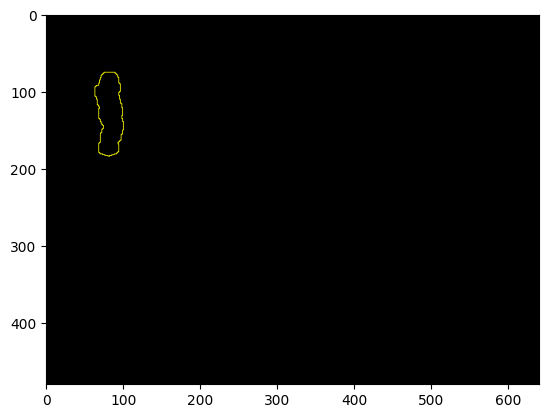

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


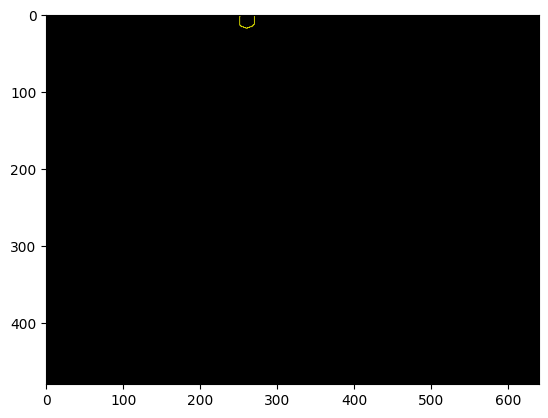

In [3]:
for cnt in contours:
    res = cv2.drawContours(frame*0.0,[cnt],0,(255,255,0),1,1)
    plt.imshow(res)
    plt.show()

In [9]:
len(contours)

2

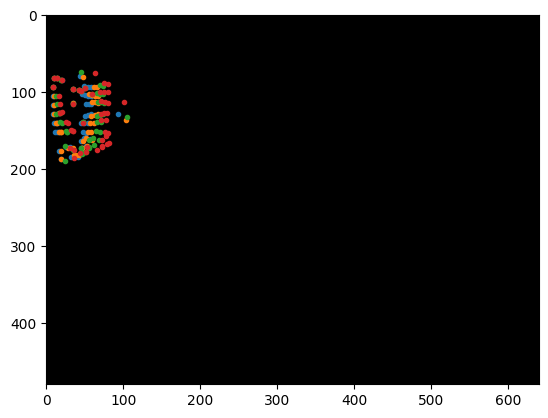

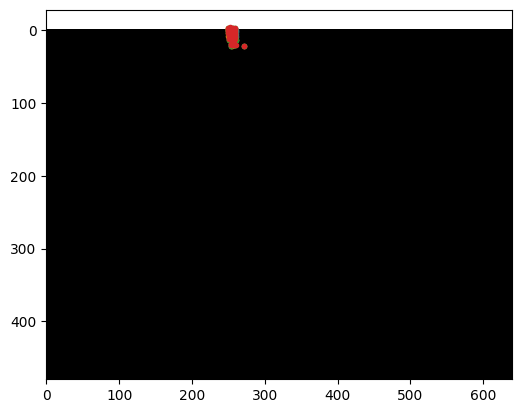

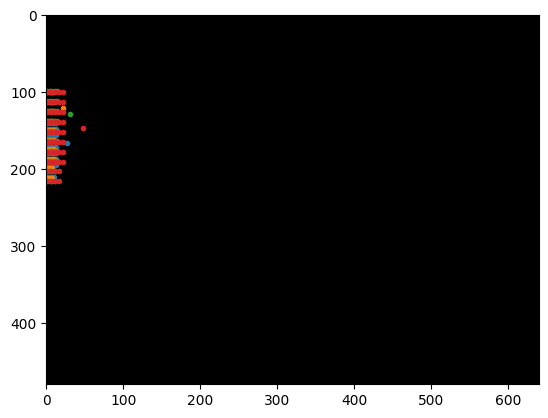

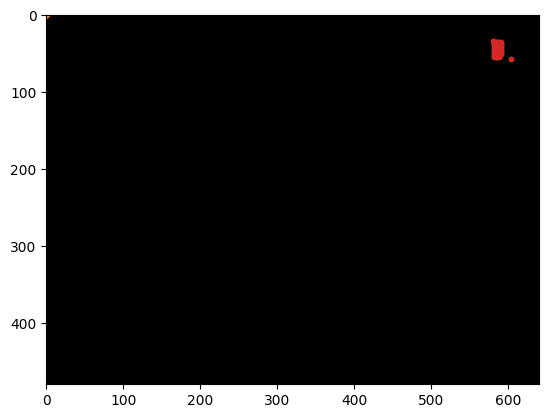

In [3]:
for _pid in [0,1,2,3]:
    _kpts = np.array(kpts)
    plt.imshow(frame*0.0)
    #_pid = 3
    for _i in range(15,25,3):
       _x = _kpts[_i,_pid,:50,0]
       _y = _kpts[_i,_pid,:50,1]
       plt.scatter(_x,_y, marker='.')
    plt.show()

In [11]:
mgd = np.meshgrid(np.linspace(x,x+w, f_pts), np.linspace(y,y+h, f_pts))
pts = np.stack(mgd).T.reshape(-1,1,2).astype(np.float32)
.shape

(10, 10)

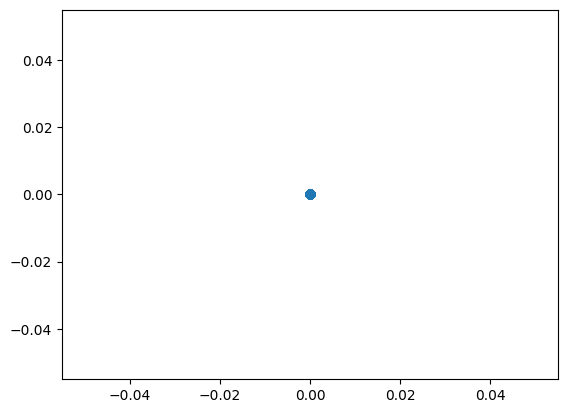

In [5]:
plt.scatter(temp[:,0], temp[:,1])

In [7]:
st.shape

(50, 1)

In [11]:
x, y, x+w, y+h

(254, 0, 274, 21)

In [29]:
x, y, w, h = 10, 10, 20, 20


In [31]:
mgd

array([[10.        , 11.05263158],
       [12.10526316, 13.15789474],
       [14.21052632, 15.26315789],
       [16.31578947, 17.36842105],
       [18.42105263, 19.47368421],
       [20.52631579, 21.57894737],
       [22.63157895, 23.68421053],
       [24.73684211, 25.78947368],
       [26.84210526, 27.89473684],
       [28.94736842, 30.        ],
       [10.        , 11.05263158],
       [12.10526316, 13.15789474],
       [14.21052632, 15.26315789],
       [16.31578947, 17.36842105],
       [18.42105263, 19.47368421],
       [20.52631579, 21.57894737],
       [22.63157895, 23.68421053],
       [24.73684211, 25.78947368],
       [26.84210526, 27.89473684],
       [28.94736842, 30.        ],
       [10.        , 11.05263158],
       [12.10526316, 13.15789474],
       [14.21052632, 15.26315789],
       [16.31578947, 17.36842105],
       [18.42105263, 19.47368421],
       [20.52631579, 21.57894737],
       [22.63157895, 23.68421053],
       [24.73684211, 25.78947368],
       [26.84210526,

In [15]:
import cv2
import glob
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
sys.path.append('D-FINE')
from torch_inf import Model
model = Model()

files = sorted(glob.glob(f'/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/testing/frames/*'))
imgs = sorted(glob.glob(files[0]+'/*jpg'))
ind = 0
for img in tqdm(imgs):
    img = cv2.imread(img)
    res = model(img)
    print(res)
    if ind == 10:break

  1%|          | 3/265 [00:00<00:33,  7.73it/s]

(array([[592.34174 ,  66.9984  , 616.7129  , 116.80351 ],
       [622.67224 ,  77.46841 , 645.79816 , 126.094826]], dtype=float32), array([0, 0]), array([0.7378304, 0.7181054], dtype=float32))
(array([[592.6416  ,  66.957634, 616.8205  , 116.97493 ],
       [622.80347 ,  76.94551 , 645.5927  , 126.07371 ]], dtype=float32), array([0, 0]), array([0.73093456, 0.6923284 ], dtype=float32))
(array([[592.94836 ,  67.00298 , 616.99945 , 117.035355],
       [623.0846  ,  76.80343 , 645.5828  , 125.96459 ]], dtype=float32), array([0, 0]), array([0.71987784, 0.65530515], dtype=float32))


  2%|▏         | 5/265 [00:00<00:27,  9.56it/s]

(array([[593.13196 ,  67.238716, 617.15497 , 117.1232  ],
       [623.7719  ,  77.02902 , 646.4646  , 126.05432 ]], dtype=float32), array([0, 0]), array([0.72110075, 0.6844223 ], dtype=float32))
(array([[593.2328  ,  67.818214, 616.85706 , 116.98244 ],
       [623.8754  ,  76.85446 , 646.3659  , 126.36409 ]], dtype=float32), array([0, 0]), array([0.71987015, 0.6790188 ], dtype=float32))
(array([[593.3012 ,  67.9212 , 616.55396, 116.96068],
       [623.57837,  76.84307, 646.2927 , 126.42969]], dtype=float32), array([0, 0]), array([0.73316085, 0.71583885], dtype=float32))


  3%|▎         | 7/265 [00:00<00:27,  9.37it/s]

(array([[593.30194 ,  67.9087  , 616.58594 , 117.02628 ],
       [623.45276 ,  76.723625, 646.261   , 126.43939 ]], dtype=float32), array([0, 0]), array([0.73431575, 0.7239264 ], dtype=float32))
(array([[593.24695 ,  68.06802 , 616.51135 , 117.097466],
       [623.4471  ,  76.74558 , 646.28217 , 126.427505]], dtype=float32), array([0, 0]), array([0.73685473, 0.72158533], dtype=float32))


  4%|▍         | 11/265 [00:01<00:24, 10.25it/s]

(array([[593.35693,  68.14076, 616.51666, 117.11987],
       [623.5067 ,  76.77016, 646.21497, 126.43227]], dtype=float32), array([0, 0]), array([0.73573405, 0.72550917], dtype=float32))
(array([[593.58276 ,  67.57392 , 616.15594 , 116.957306],
       [623.3153  ,  76.69258 , 646.1235  , 126.53209 ]], dtype=float32), array([0, 0]), array([0.72371507, 0.72256845], dtype=float32))
(array([[593.0295 ,  66.76243, 615.8288 , 117.46007],
       [623.6669 ,  76.96845, 645.8569 , 126.07745]], dtype=float32), array([0, 0]), array([0.73152435, 0.70421433], dtype=float32))


  5%|▍         | 13/265 [00:01<00:23, 10.58it/s]

(array([[592.8972 ,  66.99819, 615.6484 , 116.50007],
       [623.5535 ,  77.06692, 646.4594 , 125.25029]], dtype=float32), array([0, 0]), array([0.7340994 , 0.69760156], dtype=float32))
(array([[593.2946  ,  67.4452  , 615.68774 , 116.902214],
       [623.58167 ,  77.33744 , 646.04944 , 125.47794 ]], dtype=float32), array([0, 0]), array([0.73780835, 0.7011106 ], dtype=float32))
(array([[593.3144  ,  67.609665, 615.75305 , 117.12224 ],
       [622.9042  ,  77.7921  , 645.5424  , 126.058846]], dtype=float32), array([0, 0]), array([0.7511662, 0.7092018], dtype=float32))


  6%|▌         | 15/265 [00:01<00:24, 10.10it/s]

(array([[593.3014 ,  68.40013, 616.4807 , 117.328  ],
       [621.86847,  77.84879, 645.31146, 126.62543]], dtype=float32), array([0, 0]), array([0.74749833, 0.7179343 ], dtype=float32))
(array([[593.29156 ,  68.89659 , 616.1272  , 117.567375],
       [621.7381  ,  77.90232 , 646.7017  , 126.934494]], dtype=float32), array([0, 0]), array([0.76468796, 0.72809714], dtype=float32))


  7%|▋         | 19/265 [00:02<00:24, 10.10it/s]

(array([[593.0079  ,  69.059586, 616.51086 , 117.79654 ],
       [622.2554  ,  77.46609 , 647.1086  , 126.97556 ]], dtype=float32), array([0, 0]), array([0.7634114 , 0.72791994], dtype=float32))
(array([[593.33093 ,  68.99751 , 616.1089  , 117.68057 ],
       [622.6072  ,  77.716324, 645.89044 , 126.6268  ]], dtype=float32), array([0, 0]), array([0.76563776, 0.73414475], dtype=float32))
(array([[592.9458  ,  68.883156, 616.15594 , 117.77961 ],
       [622.3471  ,  77.73113 , 646.01215 , 126.70068 ]], dtype=float32), array([0, 0]), array([0.77017546, 0.7315979 ], dtype=float32))


  8%|▊         | 21/265 [00:02<00:22, 10.67it/s]

(array([[592.8473 ,  67.73706, 616.0139 , 117.65791],
       [623.05206,  77.20116, 645.98553, 126.94159]], dtype=float32), array([0, 0]), array([0.76137745, 0.7373654 ], dtype=float32))
(array([[592.7345  ,  67.63147 , 616.0082  , 117.528824],
       [622.1914  ,  77.61466 , 645.31476 , 126.66638 ]], dtype=float32), array([0, 0]), array([0.76827335, 0.74148065], dtype=float32))
(array([[592.9425  ,  67.43223 , 615.8463  , 116.775375],
       [621.80975 ,  77.1903  , 645.667   , 126.42375 ]], dtype=float32), array([0, 0]), array([0.7652479, 0.7349336], dtype=float32))


  9%|▊         | 23/265 [00:02<00:21, 11.04it/s]

(array([[592.4957  ,  67.41829 , 616.13544 , 116.30665 ],
       [622.276   ,  77.12857 , 646.07367 , 126.070564]], dtype=float32), array([0, 0]), array([0.75995964, 0.7209651 ], dtype=float32))
(array([[592.60925,  67.58588, 616.08887, 116.33467],
       [622.2194 ,  76.78827, 646.2083 , 125.99666]], dtype=float32), array([0, 0]), array([0.7619464, 0.7149083], dtype=float32))


  9%|▉         | 25/265 [00:02<00:23, 10.08it/s]

(array([[593.1447 ,  67.45118, 615.88544, 116.16719],
       [621.61884,  76.66185, 646.0801 , 126.24899]], dtype=float32), array([0, 0]), array([0.7662844, 0.7116778], dtype=float32))
(array([[593.1852  ,  67.681206, 616.31775 , 116.27313 ],
       [622.17847 ,  77.41292 , 645.9782  , 126.30715 ]], dtype=float32), array([0, 0]), array([0.76045483, 0.71343774], dtype=float32))


 11%|█         | 28/265 [00:02<00:27,  8.77it/s]

(array([[593.28723,  67.65178, 615.9661 , 116.76799],
       [622.22076,  77.47176, 646.0538 , 126.56247]], dtype=float32), array([0, 0]), array([0.7701572, 0.7191677], dtype=float32))
(array([[593.3086 ,  68.44575, 616.16583, 117.30216],
       [622.4963 ,  77.43988, 646.33325, 126.91562]], dtype=float32), array([0, 0]), array([0.7606357, 0.7045342], dtype=float32))


 12%|█▏        | 31/265 [00:03<00:24,  9.50it/s]

(array([[593.695  ,  68.64055, 616.1841 , 117.82085],
       [622.8914 ,  77.49388, 645.9921 , 126.96237]], dtype=float32), array([0, 0]), array([0.7551167 , 0.70423156], dtype=float32))
(array([[593.9043 ,  68.73632, 615.9605 , 117.70091],
       [622.98694,  77.41058, 645.6288 , 126.77721]], dtype=float32), array([0, 0]), array([0.76250106, 0.74221206], dtype=float32))
(array([[593.3343  ,  68.73842 , 615.7843  , 117.43764 ],
       [622.7306  ,  77.195724, 645.3752  , 126.867096]], dtype=float32), array([0, 0]), array([0.7639536, 0.7218906], dtype=float32))


 12%|█▏        | 33/265 [00:03<00:22, 10.14it/s]

(array([[593.14386 ,  68.196915, 616.36896 , 117.15736 ],
       [621.47107 ,  76.710846, 644.5725  , 127.03427 ]], dtype=float32), array([0, 0]), array([0.77506095, 0.7446686 ], dtype=float32))
(array([[592.93634 ,  68.14144 , 616.1601  , 116.65223 ],
       [622.0446  ,  77.567764, 645.10034 , 126.83497 ]], dtype=float32), array([0, 0]), array([0.773934  , 0.76098746], dtype=float32))
(array([[592.7737  ,  68.09927 , 615.7029  , 116.41983 ],
       [621.383   ,  77.693924, 645.1009  , 126.47079 ]], dtype=float32), array([0, 0]), array([0.755459, 0.729986], dtype=float32))


 13%|█▎        | 35/265 [00:03<00:22, 10.24it/s]

(array([[593.05286,  67.9671 , 616.23254, 116.29356],
       [621.63574,  77.51041, 645.1417 , 126.37771]], dtype=float32), array([0, 0]), array([0.76546496, 0.74954134], dtype=float32))
(array([[592.8987  ,  68.183754, 616.3025  , 116.29076 ],
       [621.5244  ,  77.63803 , 645.32446 , 126.49403 ]], dtype=float32), array([0, 0]), array([0.7628975, 0.7444365], dtype=float32))


 14%|█▍        | 38/265 [00:03<00:23,  9.63it/s]

(array([[593.7641  ,  67.96492 , 616.39075 , 116.66565 ],
       [621.95935 ,  77.25439 , 645.48395 , 126.917725]], dtype=float32), array([0, 0]), array([0.7530017, 0.7357228], dtype=float32))
(array([[593.50543,  68.45694, 617.07635, 116.9764 ],
       [621.62415,  77.5166 , 645.68475, 127.12506]], dtype=float32), array([0, 0]), array([0.75236326, 0.73384994], dtype=float32))
(array([[593.20337 ,  69.092285, 616.7202  , 117.09227 ],
       [621.4636  ,  77.53099 , 646.0017  , 127.24089 ]], dtype=float32), array([0, 0]), array([0.7397393 , 0.72657704], dtype=float32))


 16%|█▌        | 42/265 [00:04<00:21, 10.46it/s]

(array([[593.0231 ,  68.7272 , 616.0493 , 116.90674],
       [621.95526,  77.9857 , 645.9479 , 127.34091]], dtype=float32), array([0, 0]), array([0.74487364, 0.7349517 ], dtype=float32))
(array([[621.3485  ,  78.01944 , 645.6527  , 127.33509 ],
       [592.8681  ,  69.07852 , 616.0977  , 117.23221 ],
       [ 44.750687, 123.66629 ,  74.548744, 172.87497 ]], dtype=float32), array([ 0,  0, 10]), array([0.75807977, 0.75405896, 0.51324546], dtype=float32))
(array([[620.92926 ,  77.73738 , 645.45105 , 127.247284],
       [592.9075  ,  68.93355 , 616.1623  , 116.63426 ]], dtype=float32), array([0, 0]), array([0.76331544, 0.7592131 ], dtype=float32))


 17%|█▋        | 44/265 [00:04<00:24,  8.84it/s]

(array([[593.4037  ,  68.41124 , 616.3179  , 116.46675 ],
       [621.2745  ,  77.96479 , 645.5633  , 127.534546]], dtype=float32), array([0, 0]), array([0.7606139, 0.7400511], dtype=float32))
(array([[593.36304 ,  68.61292 , 616.2484  , 116.07564 ],
       [621.7078  ,  77.636536, 645.3227  , 127.40549 ]], dtype=float32), array([0, 0]), array([0.7574676, 0.7348597], dtype=float32))


 17%|█▋        | 46/265 [00:04<00:26,  8.15it/s]

(array([[593.08716,  68.13214, 616.4191 , 116.31529],
       [621.761  ,  77.67998, 645.2725 , 127.02438]], dtype=float32), array([0, 0]), array([0.7502075 , 0.74435544], dtype=float32))
(array([[592.9871 ,  67.33768, 616.0746 , 116.16443],
       [622.3072 ,  78.13385, 645.6835 , 126.7953 ]], dtype=float32), array([0, 0]), array([0.7463206 , 0.74535763], dtype=float32))


 18%|█▊        | 49/265 [00:05<00:23,  9.29it/s]

(array([[593.0295 ,  67.79695, 616.83167, 115.77619],
       [621.8234 ,  78.25627, 645.55725, 126.84834]], dtype=float32), array([0, 0]), array([0.74189925, 0.73435104], dtype=float32))
(array([[593.08234,  67.48854, 616.7586 , 115.42082],
       [621.70105,  78.05755, 645.8796 , 126.90067]], dtype=float32), array([0, 0]), array([0.7513261, 0.735141 ], dtype=float32))
(array([[592.9779  ,  68.71618 , 617.40717 , 115.97609 ],
       [622.00116 ,  78.581245, 646.5864  , 127.30319 ]], dtype=float32), array([0, 0]), array([0.75080955, 0.7328117 ], dtype=float32))


 19%|█▉        | 51/265 [00:05<00:21,  9.95it/s]

(array([[593.07916 ,  68.59391 , 617.4718  , 116.160904],
       [621.6813  ,  78.95053 , 646.19165 , 127.65083 ]], dtype=float32), array([0, 0]), array([0.7468808, 0.7267898], dtype=float32))
(array([[593.24927 ,  68.73892 , 616.81104 , 116.51532 ],
       [622.1234  ,  78.320435, 646.45233 , 127.436844]], dtype=float32), array([0, 0]), array([0.7499852 , 0.73704624], dtype=float32))


 20%|██        | 53/265 [00:05<00:26,  8.01it/s]

(array([[593.45166 ,  68.375114, 616.4934  , 116.20318 ],
       [622.11096 ,  78.50874 , 646.1848  , 127.46066 ]], dtype=float32), array([0, 0]), array([0.75503755, 0.7384762 ], dtype=float32))
(array([[593.2542 ,  67.81198, 616.2677 , 116.29153],
       [621.6151 ,  78.80086, 645.70667, 127.67199]], dtype=float32), array([0, 0]), array([0.76231664, 0.735059  ], dtype=float32))


 21%|██        | 56/265 [00:06<00:25,  8.15it/s]

(array([[593.60004 ,  67.80739 , 615.6113  , 116.168434],
       [622.4132  ,  78.81988 , 644.7069  , 127.41268 ]], dtype=float32), array([0, 0]), array([0.76339614, 0.7405185 ], dtype=float32))
(array([[593.3319 ,  67.49045, 615.8813 , 116.26053],
       [622.225  ,  79.15375, 644.57117, 127.10688]], dtype=float32), array([0, 0]), array([0.7553003, 0.7257749], dtype=float32))
(array([[592.98816,  67.43663, 615.43604, 115.79212],
       [622.05426,  79.11428, 644.38556, 126.979  ]], dtype=float32), array([0, 0]), array([0.757768  , 0.73795116], dtype=float32))


 22%|██▏       | 58/265 [00:06<00:22,  9.09it/s]

(array([[593.296   ,  67.239876, 615.4886  , 115.84628 ],
       [622.15393 ,  79.13024 , 644.43585 , 126.8467  ]], dtype=float32), array([0, 0]), array([0.76035476, 0.7435297 ], dtype=float32))
(array([[592.8878  ,  67.4873  , 615.5687  , 115.69985 ],
       [621.5265  ,  78.982704, 645.446   , 126.874466]], dtype=float32), array([0, 0]), array([0.756755  , 0.73705053], dtype=float32))
(array([[593.032   ,  67.394226, 616.2452  , 115.60601 ],
       [621.5771  ,  78.89328 , 646.18604 , 126.97962 ]], dtype=float32), array([0, 0]), array([0.75538695, 0.7394356 ], dtype=float32))


 23%|██▎       | 61/265 [00:06<00:23,  8.83it/s]

(array([[593.40155 ,  67.831566, 615.69305 , 115.857124],
       [621.5319  ,  78.91461 , 645.3836  , 127.259514]], dtype=float32), array([0, 0]), array([0.75568134, 0.7425137 ], dtype=float32))
(array([[593.1     ,  67.92705 , 616.06055 , 116.2292  ],
       [621.8078  ,  79.622795, 645.4361  , 127.505325],
       [ 44.462914, 123.773476,  74.79315 , 173.02655 ]], dtype=float32), array([ 0,  0, 10]), array([0.7593129 , 0.75110346, 0.5171467 ], dtype=float32))


 24%|██▍       | 63/265 [00:06<00:23,  8.44it/s]

(array([[593.3851  ,  68.09973 , 616.0781  , 116.48207 ],
       [622.30383 ,  79.671524, 645.5693  , 127.808304],
       [ 44.047543, 123.833885,  74.65475 , 173.00531 ]], dtype=float32), array([ 0,  0, 10]), array([0.752084  , 0.74089724, 0.52878433], dtype=float32))
(array([[593.6019  ,  67.833984, 615.70166 , 116.373436],
       [622.3411  ,  79.69746 , 645.6757  , 128.00317 ]], dtype=float32), array([0, 0]), array([0.7507426, 0.7450678], dtype=float32))
(array([[593.72504 ,  67.84025 , 615.6636  , 116.38762 ],
       [622.7371  ,  79.476   , 646.2896  , 127.704506]], dtype=float32), array([0, 0]), array([0.7602301 , 0.74784446], dtype=float32))


 25%|██▌       | 67/265 [00:07<00:19, 10.37it/s]

(array([[593.62164 ,  67.99193 , 615.37115 , 116.51233 ],
       [623.13806 ,  79.157425, 645.51807 , 127.44388 ]], dtype=float32), array([0, 0]), array([0.76957464, 0.75167346], dtype=float32))
(array([[593.6318  ,  67.73895 , 615.6314  , 116.289856],
       [623.1255  ,  79.37491 , 645.6729  , 127.17759 ]], dtype=float32), array([0, 0]), array([0.76692075, 0.73953754], dtype=float32))
(array([[593.7435 ,  67.12322, 615.52167, 116.37821],
       [623.2332 ,  79.02792, 645.40265, 127.07497]], dtype=float32), array([0, 0]), array([0.7616318, 0.7431328], dtype=float32))


 26%|██▌       | 69/265 [00:07<00:18, 10.88it/s]

(array([[594.15485 ,  67.12253 , 616.0882  , 116.58458 ],
       [622.77625 ,  79.09886 , 645.58185 , 127.180565]], dtype=float32), array([0, 0]), array([0.7659044, 0.7377184], dtype=float32))
(array([[594.2765  ,  67.13991 , 616.08264 , 116.873184],
       [622.49805 ,  78.8638  , 645.00055 , 126.93345 ]], dtype=float32), array([0, 0]), array([0.76230633, 0.7218826 ], dtype=float32))
(array([[594.2581  ,  67.180435, 615.98346 , 116.61282 ],
       [622.54535 ,  78.80795 , 645.67883 , 127.03444 ]], dtype=float32), array([0, 0]), array([0.7589171, 0.7095972], dtype=float32))


 27%|██▋       | 71/265 [00:07<00:19, 10.16it/s]

(array([[594.3743  ,  67.395905, 616.0452  , 116.89689 ],
       [623.05194 ,  78.46959 , 645.6319  , 127.00501 ]], dtype=float32), array([0, 0]), array([0.75583005, 0.7168787 ], dtype=float32))
(array([[594.4343 ,  67.0999 , 616.3248 , 117.45569],
       [622.58185,  78.7597 , 644.8355 , 127.3242 ]], dtype=float32), array([0, 0]), array([0.7541018 , 0.71762025], dtype=float32))


 28%|██▊       | 75/265 [00:07<00:18, 10.36it/s]

(array([[593.9104  ,  68.14955 , 616.9009  , 117.60339 ],
       [622.2121  ,  78.85806 , 647.1343  , 127.388596]], dtype=float32), array([0, 0]), array([0.73510003, 0.7112493 ], dtype=float32))
(array([[593.72955,  68.57517, 617.00757, 117.69124],
       [622.235  ,  78.83931, 646.71796, 127.31313]], dtype=float32), array([0, 0]), array([0.7375672, 0.7199733], dtype=float32))
(array([[593.68665,  68.76405, 617.3672 , 117.82202],
       [622.47253,  79.28673, 646.2225 , 127.20331]], dtype=float32), array([0, 0]), array([0.7295052, 0.7208203], dtype=float32))


 29%|██▉       | 77/265 [00:08<00:17, 10.87it/s]

(array([[594.07153 ,  68.00037 , 616.4808  , 117.046196],
       [622.26855 ,  78.92717 , 645.60297 , 127.331314]], dtype=float32), array([0, 0]), array([0.7504583, 0.7313116], dtype=float32))
(array([[593.74286 ,  68.36405 , 617.25903 , 116.80794 ],
       [621.56525 ,  79.04022 , 645.9043  , 127.164345]], dtype=float32), array([0, 0]), array([0.7370476 , 0.71085143], dtype=float32))
(array([[593.3914  ,  67.92781 , 617.1971  , 116.757645],
       [622.3214  ,  79.062   , 645.8772  , 127.19713 ]], dtype=float32), array([0, 0]), array([0.7370351, 0.729312 ], dtype=float32))


 30%|██▉       | 79/265 [00:08<00:16, 11.31it/s]

(array([[593.6157  ,  68.037476, 617.15094 , 116.735374],
       [621.76074 ,  79.17912 , 645.3158  , 127.11429 ]], dtype=float32), array([0, 0]), array([0.75068516, 0.72714037], dtype=float32))
(array([[594.1041  ,  67.9549  , 617.2285  , 116.28685 ],
       [622.2729  ,  78.79836 , 645.6324  , 127.267166]], dtype=float32), array([0, 0]), array([0.73454076, 0.72964865], dtype=float32))


 31%|███▏      | 83/265 [00:08<00:18, 10.10it/s]

(array([[593.861   ,  68.29439 , 617.2305  , 116.52276 ],
       [622.04095 ,  78.647064, 645.507   , 127.3217  ]], dtype=float32), array([0, 0]), array([0.7440344 , 0.72102076], dtype=float32))
(array([[593.92883 ,  69.064095, 616.93835 , 117.05847 ],
       [623.0631  ,  78.740326, 645.43787 , 127.29615 ],
       [ 45.176537, 123.80356 ,  74.46527 , 172.36783 ]], dtype=float32), array([ 0,  0, 10]), array([0.7438142 , 0.72242147, 0.55493873], dtype=float32))
(array([[593.6693 ,  69.43404, 616.88086, 117.29002],
       [622.1269 ,  79.03502, 645.10876, 127.38752],
       [ 44.72281, 124.0004 ,  74.45051, 172.538  ]], dtype=float32), array([ 0,  0, 10]), array([0.7424542, 0.7219461, 0.5235318], dtype=float32))


 32%|███▏      | 85/265 [00:08<00:16, 10.84it/s]

(array([[593.712   ,  69.62729 , 616.8192  , 117.524155],
       [622.4663  ,  79.91408 , 644.24884 , 127.41994 ]], dtype=float32), array([0, 0]), array([0.7558648, 0.7411143], dtype=float32))
(array([[593.4816 ,  69.80866, 616.8154 , 117.36122],
       [622.2694 ,  79.72947, 644.51294, 127.60202]], dtype=float32), array([0, 0]), array([0.76452214, 0.74349356], dtype=float32))
(array([[593.7747  ,  68.96115 , 616.8579  , 117.23027 ],
       [622.5301  ,  79.440735, 644.75055 , 127.62984 ]], dtype=float32), array([0, 0]), array([0.76388407, 0.74351585], dtype=float32))


 33%|███▎      | 87/265 [00:09<00:15, 11.25it/s]

(array([[593.45233 ,  68.97221 , 616.8142  , 117.408646],
       [622.9829  ,  79.51296 , 645.2248  , 127.432755]], dtype=float32), array([0, 0]), array([0.7655962 , 0.74903435], dtype=float32))
(array([[593.8779 ,  68.43881, 616.85785, 117.50779],
       [623.0678 ,  79.24075, 645.89   , 127.27975]], dtype=float32), array([0, 0]), array([0.7624927 , 0.74659705], dtype=float32))


 34%|███▎      | 89/265 [00:09<00:20,  8.70it/s]

(array([[593.76245 ,  67.81404 , 616.7579  , 116.70778 ],
       [623.0357  ,  79.936005, 645.64374 , 126.671646]], dtype=float32), array([0, 0]), array([0.74440753, 0.7356025 ], dtype=float32))


 34%|███▍      | 90/265 [00:09<00:23,  7.33it/s]

(array([[593.2861  ,  67.570564, 616.2058  , 116.6062  ],
       [623.2358  ,  80.210884, 645.3471  , 126.85325 ]], dtype=float32), array([0, 0]), array([0.7583039, 0.7362282], dtype=float32))


 35%|███▍      | 92/265 [00:10<00:27,  6.31it/s]

(array([[593.546   ,  67.59327 , 616.3937  , 116.45179 ],
       [622.7668  ,  80.199326, 645.15857 , 127.06527 ]], dtype=float32), array([0, 0]), array([0.76088154, 0.73922163], dtype=float32))
(array([[593.614   ,  67.66202 , 616.51196 , 117.18369 ],
       [622.9736  ,  80.070305, 645.78796 , 126.95183 ]], dtype=float32), array([0, 0]), array([0.76126194, 0.73711306], dtype=float32))


 36%|███▌      | 95/265 [00:10<00:20,  8.21it/s]

(array([[593.53906,  68.65721, 616.3719 , 117.23671],
       [623.2332 ,  80.16467, 645.87335, 126.89518]], dtype=float32), array([0, 0]), array([0.7560949, 0.738151 ], dtype=float32))
(array([[593.09845 ,  69.12498 , 616.3696  , 117.422264],
       [622.89215 ,  80.97792 , 645.4313  , 127.13665 ]], dtype=float32), array([0, 0]), array([0.75417465, 0.744677  ], dtype=float32))
(array([[593.2129  ,  69.70187 , 616.41296 , 118.13231 ],
       [622.85846 ,  80.5014  , 645.1818  , 127.48952 ],
       [ 45.439777, 123.81928 ,  74.40066 , 172.26247 ]], dtype=float32), array([ 0,  0, 10]), array([0.7590508 , 0.7406024 , 0.55716467], dtype=float32))


 37%|███▋      | 97/265 [00:10<00:18,  9.20it/s]

(array([[593.1138  ,  69.83667 , 616.4139  , 118.626854],
       [622.9259  ,  80.793816, 644.809   , 127.42285 ]], dtype=float32), array([0, 0]), array([0.75296676, 0.745685  ], dtype=float32))
(array([[593.2815  ,  69.19726 , 616.1455  , 117.5892  ],
       [622.50305 ,  80.591385, 644.1984  , 127.248215]], dtype=float32), array([0, 0]), array([0.75067466, 0.7412562 ], dtype=float32))
(array([[593.574  ,  68.56166, 616.0419 , 117.30149],
       [622.32153,  80.52841, 644.3448 , 127.28136]], dtype=float32), array([0, 0]), array([0.7565973, 0.7488734], dtype=float32))


 38%|███▊      | 100/265 [00:10<00:17,  9.41it/s]

(array([[593.3353 ,  68.09996, 615.7334 , 117.23877],
       [622.46405,  80.55699, 644.4133 , 127.00187],
       [595.583  , 458.84995, 627.85815, 480.10403]], dtype=float32), array([0, 0, 0]), array([0.7547754, 0.7479198, 0.5244671], dtype=float32))
(array([[593.38763,  67.53983, 615.4881 , 117.04642],
       [622.345  ,  80.56781, 644.44586, 127.09771],
       [588.9628 , 456.32538, 622.2645 , 480.0076 ]], dtype=float32), array([0, 0, 0]), array([0.7643457 , 0.7516871 , 0.55707765], dtype=float32))


 38%|███▊      | 102/265 [00:11<00:20,  7.89it/s]

(array([[593.71533 ,  67.508514, 615.65234 , 117.04747 ],
       [622.6694  ,  80.718414, 644.1586  , 126.96754 ]], dtype=float32), array([0, 0]), array([0.75696945, 0.75186574], dtype=float32))
(array([[593.7388 ,  67.45355, 615.5285 , 116.95111],
       [622.7891 ,  80.97324, 643.9231 , 126.90877]], dtype=float32), array([0, 0]), array([0.758243  , 0.74224454], dtype=float32))


 39%|███▉      | 104/265 [00:11<00:20,  8.00it/s]

(array([[593.64185,  67.91024, 615.6177 , 117.20032],
       [623.5416 ,  80.80995, 644.6527 , 127.13495],
       [574.64905, 446.50858, 606.07916, 480.19122]], dtype=float32), array([ 0,  0, 14]), array([0.7420558 , 0.74089885, 0.61726373], dtype=float32))
(array([[593.7885  ,  68.156845, 615.42957 , 117.000374],
       [622.98834 ,  81.287285, 644.4425  , 127.34101 ]], dtype=float32), array([0, 0]), array([0.74953794, 0.7421322 ], dtype=float32))


 40%|████      | 106/265 [00:11<00:19,  8.07it/s]

(array([[ 5.6553650e+02,  4.3845914e+02,  6.0195428e+02,  4.8022528e+02],
       [ 5.9318622e+02,  6.8764084e+01,  6.1510205e+02,  1.1727994e+02],
       [ 6.2238672e+02,  8.0953819e+01,  6.4364856e+02,  1.2731203e+02],
       [-1.9938275e-02,  1.5147563e+02,  2.3321848e+01,  2.1787328e+02]],
      dtype=float32), array([14,  0,  0,  0]), array([0.77218145, 0.75649   , 0.74213535, 0.6214179 ], dtype=float32))
(array([[5.9329498e+02, 6.8793152e+01, 6.1528815e+02, 1.1782216e+02],
       [6.2267761e+02, 8.0750244e+01, 6.4360364e+02, 1.2735414e+02],
       [9.4299033e-02, 1.4804100e+02, 2.3761478e+01, 2.1763583e+02]],
      dtype=float32), array([0, 0, 0]), array([0.74886596, 0.7476318 , 0.6986785 ], dtype=float32))


 41%|████      | 108/265 [00:11<00:20,  7.50it/s]

(array([[5.9331970e+02, 6.8668587e+01, 6.1500854e+02, 1.1787805e+02],
       [6.2237646e+02, 8.0503304e+01, 6.4366638e+02, 1.2734717e+02],
       [5.5596802e+02, 4.3012042e+02, 5.9428113e+02, 4.8001883e+02],
       [1.3274539e-01, 1.4069389e+02, 2.3242388e+01, 2.1772826e+02]],
      dtype=float32), array([0, 0, 0, 0]), array([0.75420195, 0.7500773 , 0.72809017, 0.6989674 ], dtype=float32))
(array([[5.93060791e+02, 6.81854858e+01, 6.14645752e+02, 1.17768188e+02],
       [6.22196106e+02, 8.07445908e+01, 6.43357361e+02, 1.27006485e+02],
       [5.45669556e+02, 4.26183014e+02, 5.90398132e+02, 4.79949982e+02],
       [5.03008962e-02, 1.19966354e+02, 2.25558033e+01, 2.17495102e+02]],
      dtype=float32), array([0, 0, 0, 0]), array([0.7509317, 0.7504455, 0.7463202, 0.6586336], dtype=float32))


 41%|████      | 109/265 [00:12<00:25,  6.09it/s]

(array([[-4.83046770e-02,  1.17756256e+02,  2.33295135e+01,
         2.17117004e+02],
       [ 6.22384338e+02,  8.04022369e+01,  6.43836487e+02,
         1.26693535e+02],
       [ 5.93326965e+02,  6.76905899e+01,  6.14884705e+02,
         1.17131126e+02],
       [ 5.41685669e+02,  4.22983643e+02,  5.93256409e+02,
         4.80064819e+02]], dtype=float32), array([0, 0, 0, 0]), array([0.7625047 , 0.7529889 , 0.7375628 , 0.73413604], dtype=float32))


 42%|████▏     | 110/265 [00:12<00:28,  5.45it/s]

(array([[-2.79662013e-02,  1.18267021e+02,  2.63413048e+01,
         2.17246002e+02],
       [ 6.22173035e+02,  8.02214813e+01,  6.44299438e+02,
         1.26542030e+02],
       [ 5.93523682e+02,  6.70556107e+01,  6.14945374e+02,
         1.17104904e+02],
       [ 5.36285461e+02,  4.20448608e+02,  5.92743835e+02,
         4.80051666e+02]], dtype=float32), array([0, 0, 0, 0]), array([0.8271876, 0.7547138, 0.7321493, 0.7008708], dtype=float32))


 42%|████▏     | 112/265 [00:12<00:27,  5.48it/s]

(array([[-5.7533205e-02,  1.1995893e+02,  3.0349649e+01,  2.1682867e+02],
       [ 5.9330524e+02,  6.7304108e+01,  6.1476837e+02,  1.1757418e+02],
       [ 6.2263934e+02,  8.0422653e+01,  6.4404492e+02,  1.2660131e+02],
       [ 5.3080713e+02,  4.1787708e+02,  5.8730609e+02,  4.7991229e+02]],
      dtype=float32), array([0, 0, 0, 0]), array([0.8583152, 0.7497575, 0.749628 , 0.7137075], dtype=float32))
(array([[-9.9692971e-02,  1.1910826e+02,  3.2719318e+01,  2.1674905e+02],
       [ 5.9313232e+02,  6.7463860e+01,  6.1473859e+02,  1.1730316e+02],
       [ 6.2262262e+02,  8.1002853e+01,  6.4382239e+02,  1.2672257e+02],
       [ 5.2322034e+02,  4.1661557e+02,  5.8141656e+02,  4.8000385e+02]],
      dtype=float32), array([0, 0, 0, 0]), array([0.8531858 , 0.75622714, 0.751063  , 0.73739636], dtype=float32))


 43%|████▎     | 115/265 [00:13<00:18,  7.90it/s]

(array([[4.1293037e-01, 1.1950512e+02, 3.8734619e+01, 2.1573248e+02],
       [5.9285693e+02, 6.7538307e+01, 6.1468213e+02, 1.1741550e+02],
       [6.2262994e+02, 8.0863937e+01, 6.4393219e+02, 1.2670596e+02],
       [5.1356726e+02, 4.1513470e+02, 5.7530603e+02, 4.8001773e+02]],
      dtype=float32), array([0, 0, 0, 0]), array([0.8117794 , 0.75185406, 0.7429314 , 0.6766281 ], dtype=float32))
(array([[  4.9577026, 119.68477  ,  49.26686  , 215.11711  ],
       [592.7156   ,  67.4694   , 614.8167   , 117.13988  ],
       [622.18427  ,  80.904465 , 643.9164   , 127.02679  ],
       [500.86234  , 413.84854  , 569.51044  , 479.87558  ],
       [ 47.413025 , 124.071976 ,  74.3883   , 172.20045  ]],
      dtype=float32), array([ 0,  0,  0,  0, 28]), array([0.8144525 , 0.7619787 , 0.75067466, 0.7425705 , 0.53410304],
      dtype=float32))
(array([[495.14404  , 411.94363  , 562.5566   , 479.9917   ],
       [  5.9128647, 120.33444  ,  51.572544 , 215.91638  ],
       [592.5396   ,  67.89232  , 61

 44%|████▍     | 117/265 [00:13<00:17,  8.42it/s]

(array([[488.63577  , 410.65082  , 555.9525   , 479.8479   ],
       [  6.6553836, 119.04367  ,  53.685806 , 215.596    ],
       [592.56213  ,  67.88974  , 615.12427  , 117.03954  ],
       [621.7507   ,  81.17517  , 644.05054  , 127.00187  ],
       [ 46.977085 , 124.23268  ,  73.87362  , 172.54225  ]],
      dtype=float32), array([0, 0, 0, 0, 0]), array([0.81987494, 0.8089672 , 0.7555368 , 0.75313765, 0.5611259 ],
      dtype=float32))
(array([[483.67468  , 408.4527   , 548.5236   , 479.83704  ],
       [  7.4953613, 118.575325 ,  50.338615 , 216.1753   ],
       [592.6929   ,  67.83121  , 615.41156  , 117.46018  ],
       [621.90405  ,  81.201294 , 643.8874   , 127.26843  ],
       [ 41.11267  , 123.16936  ,  72.701385 , 207.21118  ],
       [ 46.780262 , 124.32884  ,  74.72335  , 172.47682  ]],
      dtype=float32), array([0, 0, 0, 0, 0, 0]), array([0.81119704, 0.7914335 , 0.7517615 , 0.75051874, 0.52239066,
       0.5222956 ], dtype=float32))


 45%|████▍     | 119/265 [00:13<00:18,  7.71it/s]

(array([[480.17487 , 405.74847 , 543.61346 , 479.8933  ],
       [  8.419386, 117.44012 ,  46.649246, 216.32886 ],
       [621.8839  ,  81.54656 , 644.04956 , 127.25537 ],
       [592.5996  ,  67.54593 , 615.2003  , 117.15778 ],
       [ 41.778248, 122.74947 ,  72.225075, 210.87259 ]], dtype=float32), array([0, 0, 0, 0, 0]), array([0.82178783, 0.79258335, 0.75208586, 0.7480838 , 0.686768  ],
      dtype=float32))
(array([[ 17.16308 , 117.31053 ,  50.89793 , 213.53198 ],
       [477.0805  , 402.88696 , 535.8812  , 479.86862 ],
       [622.4124  ,  81.45684 , 643.69696 , 127.145546],
       [592.8448  ,  67.53705 , 614.8455  , 117.606514],
       [ 48.201237, 123.81028 ,  74.36167 , 171.91946 ],
       [ 41.38091 , 122.77805 ,  70.44118 , 210.68504 ]], dtype=float32), array([0, 0, 0, 0, 0, 0]), array([0.8206496 , 0.80149937, 0.756938  , 0.7474806 , 0.5389483 ,
       0.5159663 ], dtype=float32))


 46%|████▌     | 121/265 [00:13<00:20,  7.18it/s]

(array([[ 19.861393, 116.30397 ,  53.429688, 211.80692 ],
       [471.72025 , 399.6857  , 531.6967  , 479.88544 ],
       [592.58154 ,  67.92585 , 614.7856  , 117.844894],
       [622.4148  ,  81.06661 , 643.911   , 126.77131 ],
       [ 16.347113, 192.60349 ,  38.486687, 214.54144 ],
       [ 49.284107, 123.40413 ,  74.64844 , 171.85367 ]], dtype=float32), array([ 0,  0,  0,  0, 36,  0]), array([0.8454581 , 0.8342339 , 0.7555485 , 0.75354713, 0.6347237 ,
       0.62734663], dtype=float32))
(array([[ 24.22375 , 115.55281 ,  64.234505, 210.69951 ],
       [445.7452  , 393.2535  , 519.5087  , 479.9274  ],
       [622.1999  ,  80.86222 , 643.4158  , 126.66757 ],
       [592.4462  ,  67.3746  , 614.9743  , 117.23465 ],
       [ 29.13265 , 193.89287 ,  58.685776, 211.73764 ]], dtype=float32), array([ 0,  0,  0,  0, 36]), array([0.8066803 , 0.7814093 , 0.7502461 , 0.74572563, 0.5974254 ],
      dtype=float32))


 46%|████▋     | 123/265 [00:14<00:17,  8.06it/s]

(array([[443.5796  , 389.8344  , 513.9496  , 479.8921  ],
       [ 25.956264, 115.06468 ,  66.23035 , 211.47342 ],
       [622.79333 ,  81.3945  , 643.75116 , 126.48172 ],
       [592.6016  ,  67.20317 , 615.1493  , 117.07127 ],
       [ 49.555073, 122.13132 ,  74.05079 , 171.02094 ],
       [ 36.93699 , 200.52972 ,  58.424545, 212.70413 ]], dtype=float32), array([ 0,  0,  0,  0,  0, 36]), array([0.816771  , 0.8110426 , 0.75246537, 0.7452947 , 0.5591037 ,
       0.5518262 ], dtype=float32))
(array([[438.7816  , 386.70554 , 510.82242 , 479.80432 ],
       [ 30.64632 , 115.91236 ,  67.45572 , 212.56465 ],
       [622.555   ,  80.834816, 643.5932  , 126.763016],
       [592.4307  ,  67.21852 , 615.22253 , 117.00052 ],
       [ 50.160984, 121.74239 ,  74.34668 , 172.0925  ]], dtype=float32), array([0, 0, 0, 0, 0]), array([0.84691924, 0.77022666, 0.7491202 , 0.7214502 , 0.62053084],
      dtype=float32))
(array([[432.85986 , 384.3797  , 506.14438 , 479.76404 ],
       [ 34.702267, 115.74242

 47%|████▋     | 125/265 [00:14<00:15,  9.22it/s]

(array([[ 38.444042, 118.14488 ,  79.09679 , 212.22119 ],
       [428.5539  , 382.17825 , 501.1626  , 479.86798 ],
       [622.28973 ,  80.788895, 643.8288  , 126.91707 ],
       [592.66125 ,  67.293236, 615.3278  , 116.98912 ],
       [457.88406 , 414.50345 , 500.62155 , 479.94388 ]], dtype=float32), array([ 0,  0,  0,  0, 24]), array([0.8620978 , 0.856014  , 0.7408139 , 0.72296417, 0.5912191 ],
      dtype=float32))
(array([[420.20197 , 380.1686  , 493.06497 , 479.82776 ],
       [ 37.343815, 119.196465,  82.58458 , 211.77856 ],
       [621.97107 ,  81.00145 , 643.7961  , 127.01281 ],
       [592.819   ,  67.67156 , 615.3205  , 117.81045 ],
       [454.56387 , 411.1002  , 494.58295 , 479.48636 ]], dtype=float32), array([ 0,  0,  0,  0, 24]), array([0.827807  , 0.82442915, 0.75060284, 0.741238  , 0.5905425 ],
      dtype=float32))


 48%|████▊     | 128/265 [00:14<00:14,  9.18it/s]

(array([[ 39.280964, 117.43017 ,  90.93609 , 211.13211 ],
       [413.68405 , 377.61325 , 489.51028 , 479.70486 ],
       [621.70215 ,  81.021835, 643.37885 , 127.02314 ],
       [592.8306  ,  67.20147 , 614.8204  , 117.626205],
       [446.29944 , 407.37906 , 489.76035 , 477.5758  ]], dtype=float32), array([ 0,  0,  0,  0, 24]), array([0.8748371 , 0.8442355 , 0.7521507 , 0.7465303 , 0.73184943],
      dtype=float32))
(array([[ 41.225445, 117.24809 ,  92.41559 , 210.79439 ],
       [407.29984 , 374.81598 , 484.9616  , 479.3668  ],
       [621.6076  ,  81.04331 , 643.412   , 127.08272 ],
       [592.80804 ,  67.29983 , 614.72205 , 117.57644 ],
       [445.96045 , 404.7175  , 484.96167 , 476.17612 ]], dtype=float32), array([ 0,  0,  0,  0, 24]), array([0.8742747 , 0.87302595, 0.75381553, 0.7477569 , 0.57873976],
      dtype=float32))


 49%|████▊     | 129/265 [00:14<00:15,  8.63it/s]

(array([[400.43314 , 371.33618 , 479.0178  , 478.50827 ],
       [ 42.035374, 116.8408  ,  94.68477 , 210.61066 ],
       [621.9227  ,  80.789795, 643.2345  , 126.906136],
       [592.8043  ,  67.24735 , 614.7486  , 117.51069 ],
       [446.25256 , 268.08203 , 504.59308 , 298.1341  ]], dtype=float32), array([ 0,  0,  0,  0, 29]), array([0.8847303 , 0.8761522 , 0.75618756, 0.7534733 , 0.5003323 ],
      dtype=float32))
(array([[393.3735  , 368.02676 , 473.28052 , 477.11197 ],
       [ 44.570805, 115.66601 ,  95.73593 , 210.48091 ],
       [622.5539  ,  80.53654 , 643.5261  , 127.00899 ],
       [592.9179  ,  67.1943  , 614.8447  , 117.22927 ]], dtype=float32), array([0, 0, 0, 0]), array([0.88356185, 0.8775183 , 0.76416606, 0.7553733 ], dtype=float32))
(array([[390.29617 , 364.07428 , 466.76028 , 479.582   ],
       [ 47.34676 , 114.65095 ,  94.96094 , 210.30841 ],
       [622.2861  ,  80.516785, 643.52075 , 126.77253 ],
       [593.0928  ,  66.866196, 614.4393  , 117.07837 ],
       [42

 50%|█████     | 133/265 [00:15<00:13,  9.65it/s]

(array([[386.9635  , 360.2602  , 462.3282  , 479.502   ],
       [ 48.365196, 114.04278 ,  94.81071 , 209.79753 ],
       [622.2886  ,  80.65616 , 643.27905 , 126.74086 ],
       [592.887   ,  66.95479 , 614.5813  , 117.43442 ],
       [420.3686  , 393.69116 , 459.87787 , 462.28296 ]], dtype=float32), array([ 0,  0,  0,  0, 24]), array([0.8926614 , 0.8537311 , 0.7662062 , 0.75829417, 0.72549725],
      dtype=float32))
(array([[382.58432 , 356.89648 , 453.78232 , 479.81427 ],
       [ 48.934586, 113.28638 ,  94.210266, 209.34691 ],
       [415.74713 , 393.19412 , 456.03397 , 458.99268 ],
       [593.1417  ,  66.73685 , 614.8752  , 117.30289 ],
       [622.5102  ,  80.4082  , 643.4923  , 126.96334 ]], dtype=float32), array([ 0,  0, 24,  0,  0]), array([0.8442875 , 0.8154302 , 0.76693195, 0.7622646 , 0.7579284 ],
      dtype=float32))


 51%|█████     | 135/265 [00:15<00:16,  7.82it/s]

(array([[380.16956 , 353.79404 , 447.6065  , 479.85095 ],
       [ 49.338577, 111.425026,  97.79804 , 208.44537 ],
       [593.1489  ,  66.781586, 615.07574 , 117.24742 ],
       [410.019   , 387.71417 , 452.19763 , 455.74265 ],
       [622.3479  ,  80.370155, 643.5566  , 126.862625]], dtype=float32), array([ 0,  0,  0, 24,  0]), array([0.830994  , 0.81144524, 0.76383257, 0.7617787 , 0.7556964 ],
      dtype=float32))
(array([[380.86072 , 351.79373 , 439.31613 , 479.74933 ],
       [ 49.732094, 110.77858 ,  99.55293 , 209.83301 ],
       [592.85815 ,  66.70042 , 615.23846 , 117.05205 ],
       [621.9103  ,  80.49026 , 643.70935 , 126.976105],
       [406.7733  , 383.3096  , 448.74954 , 452.63312 ],
       [ 76.90469 , 156.59981 ,  99.3509  , 187.30894 ]], dtype=float32), array([ 0,  0,  0,  0, 24, 26]), array([0.8518801 , 0.7688963 , 0.76715076, 0.7509839 , 0.7406322 ,
       0.6079266 ], dtype=float32))


 52%|█████▏    | 137/265 [00:15<00:14,  8.87it/s]

(array([[376.5277  , 349.90665 , 439.8872  , 479.6908  ],
       [402.76413 , 381.57962 , 444.0119  , 449.80826 ],
       [592.84436 ,  66.885124, 615.566   , 117.69475 ],
       [621.6699  ,  80.06407 , 644.0073  , 126.92851 ],
       [ 52.802776, 109.92518 , 103.987   , 210.1466  ],
       [ 44.51223 , 127.395256,  72.691   , 171.4959  ]], dtype=float32), array([ 0, 24,  0,  0,  0, 28]), array([0.8690599 , 0.8001009 , 0.7566025 , 0.7468631 , 0.73590416,
       0.5269106 ], dtype=float32))
(array([[369.69284 , 348.57834 , 434.49994 , 479.63132 ],
       [ 71.03739 , 110.001114, 111.76427 , 209.3261  ],
       [402.48972 , 382.9001  , 438.76718 , 447.04434 ],
       [593.3734  ,  66.71294 , 615.1366  , 117.352234],
       [621.1772  ,  80.518555, 643.2928  , 127.05581 ],
       [ 44.65965 , 125.75641 ,  73.511734, 171.63142 ],
       [ 80.70243 , 199.15544 , 112.02041 , 210.46924 ]], dtype=float32), array([ 0,  0, 24,  0,  0, 28, 36]), array([0.86832607, 0.83020675, 0.7815057 , 0.75513

 53%|█████▎    | 141/265 [00:15<00:11, 10.61it/s]

(array([[359.7493  , 346.5814  , 428.49582 , 479.55853 ],
       [ 76.60039 , 111.014175, 125.546394, 209.08336 ],
       [592.9153  ,  67.18104 , 615.3405  , 118.08553 ],
       [620.898   ,  80.614426, 643.53894 , 127.25358 ],
       [389.6652  , 381.27725 , 428.0363  , 442.90036 ],
       [446.78293 , 268.30582 , 504.52274 , 297.75262 ],
       [ 44.93735 , 124.5203  ,  73.84789 , 171.98764 ]], dtype=float32), array([ 0,  0,  0,  0, 24, 29, 28]), array([0.89488864, 0.88580847, 0.753933  , 0.7493222 , 0.71516716,
       0.6015724 , 0.5611714 ], dtype=float32))
(array([[ 77.30111 , 111.16507 , 129.23247 , 209.21176 ],
       [347.10086 , 345.93747 , 425.41467 , 479.54044 ],
       [383.39108 , 378.76166 , 422.888   , 440.52417 ],
       [592.9156  ,  66.98814 , 614.9653  , 117.506874],
       [621.18036 ,  80.53269 , 643.62006 , 127.34855 ],
       [446.33533 , 267.9764  , 504.50522 , 297.7988  ],
       [ 44.895393, 124.69409 ,  73.65531 , 172.19746 ]], dtype=float32), array([ 0,  0,

 54%|█████▍    | 143/265 [00:16<00:11, 10.76it/s]

(array([[ 78.64407 , 109.78875 , 131.4197  , 208.83888 ],
       [328.77075 , 344.81042 , 418.1988  , 479.83862 ],
       [377.3082  , 374.20853 , 411.68686 , 437.3673  ],
       [593.23846 ,  66.93309 , 614.8402  , 117.10899 ],
       [621.6978  ,  80.36499 , 643.7373  , 126.97712 ],
       [ 45.34308 , 124.509155,  73.31913 , 172.00592 ]], dtype=float32), array([ 0,  0, 24,  0,  0, 28]), array([0.91552   , 0.87050706, 0.76380324, 0.7465762 , 0.73716366,
       0.6193181 ], dtype=float32))
(array([[ 81.40985 , 109.72679 , 131.80037 , 209.00182 ],
       [325.05792 , 343.94604 , 415.7844  , 479.75858 ],
       [368.42758 , 372.8094  , 405.56116 , 435.7744  ],
       [621.73    ,  80.4044  , 643.37836 , 127.11069 ],
       [593.40247 ,  67.14146 , 614.6156  , 117.11409 ],
       [ 45.10759 , 124.36595 ,  73.710785, 172.07872 ]], dtype=float32), array([ 0,  0, 24,  0,  0, 28]), array([0.9122679 , 0.86422324, 0.75709486, 0.7472126 , 0.74211615,
       0.68100554], dtype=float32))
(array([

 55%|█████▍    | 145/265 [00:16<00:13,  9.22it/s]

(array([[ 97.09157 , 107.17379 , 133.39536 , 204.58813 ],
       [325.2807  , 338.5584  , 400.2514  , 479.83167 ],
       [621.9216  ,  80.56194 , 643.37555 , 127.005226],
       [593.7609  ,  66.98978 , 614.9192  , 117.21232 ],
       [351.45096 , 366.5133  , 387.14856 , 430.57605 ],
       [ 99.19338 , 191.11784 , 131.11246 , 204.95782 ],
       [575.03186 , 257.36136 , 628.9663  , 284.76816 ],
       [446.9138  , 268.04285 , 504.91922 , 297.4548  ],
       [ 46.26453 , 124.36123 ,  75.24764 , 170.82864 ]], dtype=float32), array([ 0,  0,  0,  0, 24, 36, 29, 29, 28]), array([0.8933451 , 0.86832905, 0.7461869 , 0.74211866, 0.58521664,
       0.5301988 , 0.5215391 , 0.50634694, 0.5016227 ], dtype=float32))


 56%|█████▌    | 148/265 [00:16<00:13,  8.86it/s]

(array([[321.28635, 336.4757 , 390.92896, 479.72632],
       [102.62344, 106.95488, 135.05699, 204.42827],
       [622.05444,  80.68833, 643.5147 , 126.83928],
       [343.6819 , 364.13373, 381.64432, 427.86066],
       [593.90216,  67.37164, 614.97736, 117.39817]], dtype=float32), array([ 0,  0,  0, 24,  0]), array([0.8970743 , 0.88569504, 0.7431949 , 0.7429288 , 0.73790085],
      dtype=float32))
(array([[316.9448  , 333.75772 , 381.023   , 479.61383 ],
       [104.98533 , 106.505875, 138.98076 , 204.38553 ],
       [593.898   ,  67.068474, 614.7625  , 117.17082 ],
       [621.1304  ,  80.97409 , 643.15485 , 127.06776 ],
       [345.54102 , 360.87463 , 376.93347 , 423.78247 ]], dtype=float32), array([ 0,  0,  0,  0, 24]), array([0.90568846, 0.8832756 , 0.74999064, 0.74768066, 0.62314624],
      dtype=float32))
(array([[107.47039 , 106.72386 , 142.34816 , 204.53084 ],
       [310.41537 , 331.64044 , 370.1553  , 479.38092 ],
       [336.06613 , 355.63104 , 371.87756 , 423.4857  ],
    

 57%|█████▋    | 150/265 [00:16<00:11,  9.99it/s]

(array([[110.60149 , 106.95248 , 147.0636  , 203.42677 ],
       [303.28796 , 329.27136 , 361.68625 , 479.58115 ],
       [327.89127 , 354.91104 , 366.63818 , 422.60217 ],
       [621.2484  ,  80.68475 , 643.62506 , 127.376976],
       [593.4599  ,  67.83338 , 615.1355  , 117.5462  ]], dtype=float32), array([ 0,  0, 24,  0,  0]), array([0.90381354, 0.84280986, 0.77390695, 0.7462373 , 0.7326481 ],
      dtype=float32))
(array([[1.12927155e+02, 1.06739502e+02, 1.56129395e+02, 2.02863434e+02],
       [2.98440643e+02, 3.27661682e+02, 3.50755859e+02, 4.79148956e+02],
       [3.22876068e+02, 3.56342010e+02, 3.62361969e+02, 4.19949768e+02],
       [6.21169312e+02, 8.06206818e+01, 6.43506042e+02, 1.27343201e+02],
       [5.93362244e+02, 6.76408768e+01, 6.15060303e+02, 1.17516800e+02],
       [2.86868811e-01, 1.72566711e+02, 5.46353912e+01, 2.44337311e+02]],
      dtype=float32), array([ 0,  0, 24,  0,  0,  1]), array([0.9127956 , 0.8396007 , 0.7942872 , 0.743571  , 0.7345891 ,
       0.5525698

 57%|█████▋    | 152/265 [00:17<00:10, 10.42it/s]

(array([[ 1.14555954e+02,  1.07139618e+02,  1.65142319e+02,
         2.02402954e+02],
       [ 2.82998047e+02,  3.25940094e+02,  3.50145813e+02,
         4.79275940e+02],
       [ 3.15562622e+02,  3.52909973e+02,  3.52756836e+02,
         4.16253662e+02],
       [-1.28312886e-01,  1.44242996e+02,  3.50052032e+01,
         2.31136322e+02],
       [ 6.20929565e+02,  8.00979691e+01,  6.43710693e+02,
         1.26935516e+02],
       [ 5.93225891e+02,  6.73196106e+01,  6.15055359e+02,
         1.17467796e+02],
       [ 5.26769733e+00,  1.77502838e+02,  7.50044403e+01,
         2.43038696e+02]], dtype=float32), array([ 0,  0, 24,  0,  0,  0,  1]), array([0.92180073, 0.8680104 , 0.83170325, 0.7718468 , 0.75784355,
       0.7432413 , 0.7431019 ], dtype=float32))
(array([[115.58254  , 106.96232  , 166.8591   , 202.33743  ],
       [275.46606  , 324.39755  , 350.23236  , 479.3813   ],
       [  1.7575212, 144.45972  ,  48.608665 , 231.41135  ],
       [311.27014  , 353.0626   , 347.2173   , 414.

 58%|█████▊    | 154/265 [00:17<00:11,  9.71it/s]

(array([[ 1.16734741e+02,  1.07000061e+02,  1.67147415e+02,
         2.02436401e+02],
       [-5.12256622e-02,  1.80809296e+02,  9.72690659e+01,
         2.44224503e+02],
       [ 2.69997803e+02,  3.23138519e+02,  3.48811249e+02,
         4.79249512e+02],
       [ 1.27589016e+01,  1.42552200e+02,  6.04648933e+01,
         2.30409042e+02],
       [ 3.01878845e+02,  3.52598480e+02,  3.42629974e+02,
         4.12602264e+02],
       [ 5.92904114e+02,  6.72399445e+01,  6.15070374e+02,
         1.17803635e+02],
       [ 6.20699097e+02,  8.03957443e+01,  6.43312378e+02,
         1.26807861e+02],
       [ 4.59409218e+01,  1.23395035e+02,  7.32398376e+01,
         1.73559296e+02]], dtype=float32), array([ 0,  1,  0,  0, 24,  0,  0,  0]), array([0.9219516 , 0.9044272 , 0.89873034, 0.8198809 , 0.7881221 ,
       0.7540205 , 0.7371856 , 0.5380342 ], dtype=float32))
(array([[  5.091188, 181.97153 , 109.06307 , 245.20912 ],
       [118.91484 , 106.59147 , 167.8729  , 202.30237 ],
       [264.78735 ,

 60%|█████▉    | 158/265 [00:17<00:11,  9.39it/s]

(array([[ 15.523072, 180.83734 , 120.47106 , 245.20099 ],
       [261.46783 , 318.38544 , 348.42645 , 478.90286 ],
       [121.81416 , 106.045616, 168.38046 , 202.17665 ],
       [294.38306 , 346.54385 , 330.6192  , 410.0339  ],
       [ 35.617085, 141.90309 ,  83.23694 , 230.56544 ],
       [621.12164 ,  80.1802  , 643.2936  , 126.84371 ],
       [593.1792  ,  67.30192 , 615.0091  , 117.2516  ],
       [ 44.06758 , 123.33352 ,  74.872086, 169.34106 ]], dtype=float32), array([ 1,  0,  0, 24,  0,  0,  0,  0]), array([0.93285614, 0.91031766, 0.8917271 , 0.7786215 , 0.7630872 ,
       0.7517703 , 0.7507294 , 0.5762685 ], dtype=float32))
(array([[ 28.265268, 178.8467  , 132.56265 , 244.80574 ],
       [258.5818  , 315.3928  , 341.64676 , 479.36118 ],
       [130.33437 , 105.75835 , 169.0982  , 202.14514 ],
       [285.5417  , 345.2987  , 324.7731  , 408.47928 ],
       [621.5376  ,  80.398766, 643.1426  , 127.00008 ],
       [593.4579  ,  67.29909 , 615.16675 , 116.91644 ],
       [ 46.171

 60%|██████    | 160/265 [00:18<00:11,  9.03it/s]

(array([[ 48.913452, 179.42865 , 155.35939 , 244.20627 ],
       [140.73856 , 104.68688 , 174.38223 , 202.40044 ],
       [253.57458 , 310.38135 , 310.77252 , 463.1841  ],
       [ 68.223114, 141.19887 , 118.07826 , 226.24478 ],
       [279.48184 , 341.7482  , 312.58405 , 400.93674 ],
       [621.61    ,  80.59477 , 643.5959  , 127.14991 ],
       [593.3429  ,  67.98676 , 614.7579  , 117.19455 ],
       [ 44.723843, 123.618095,  72.60639 , 173.87775 ],
       [266.29517 , 445.71246 , 321.5353  , 478.6685  ]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0,  0, 36]), array([0.93775576, 0.900522  , 0.833432  , 0.8276466 , 0.82540333,
       0.74655986, 0.73606515, 0.56534266, 0.50396216], dtype=float32))
(array([[ 58.535255, 178.52614 , 167.12721 , 243.11632 ],
       [143.69878 , 104.35287 , 177.24857 , 202.49908 ],
       [250.64523 , 307.91663 , 313.3878  , 475.02234 ],
       [ 80.17741 , 140.70108 , 130.00114 , 229.47684 ],
       [275.1725  , 336.30872 , 307.35904 , 398.81705 ],

 61%|██████    | 161/265 [00:18<00:14,  7.42it/s]

(array([[ 70.00173 , 176.0277  , 178.59169 , 242.95175 ],
       [245.21982 , 305.9623  , 302.71368 , 472.0064  ],
       [145.9799  , 103.989746, 180.42328 , 201.27382 ],
       [ 92.46135 , 140.19524 , 139.4217  , 227.50533 ],
       [268.68906 , 334.32318 , 302.71008 , 396.60907 ],
       [593.43823 ,  67.526825, 614.30115 , 117.51147 ],
       [622.4359  ,  80.62962 , 643.5915  , 126.91743 ]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0]), array([0.92104715, 0.8874285 , 0.87336427, 0.8507068 , 0.7512541 ,
       0.7450531 , 0.7421192 ], dtype=float32))


 62%|██████▏   | 163/265 [00:18<00:14,  6.93it/s]

(array([[ 82.22344 , 173.24792 , 189.25757 , 242.46385 ],
       [240.55093 , 304.30148 , 297.16602 , 468.48416 ],
       [103.060555, 139.78474 , 149.84122 , 231.02106 ],
       [147.1429  , 104.127045, 184.89595 , 204.82181 ],
       [258.18045 , 333.06125 , 298.56955 , 394.36215 ],
       [593.22766 ,  67.56818 , 614.29224 , 117.36815 ],
       [622.30475 ,  80.65184 , 643.523   , 126.962524]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0]), array([0.9087021 , 0.89971966, 0.8683808 , 0.8319254 , 0.79677135,
       0.746337  , 0.7383901 ], dtype=float32))
(array([[ 93.09453 , 175.22879 , 200.80664 , 242.11409 ],
       [234.94298 , 303.64413 , 294.30515 , 463.9516  ],
       [115.592125, 138.98581 , 158.5619  , 231.05838 ],
       [256.19827 , 333.6368  , 294.4125  , 391.69623 ],
       [593.3391  ,  67.51814 , 614.2256  , 116.98553 ],
       [622.8175  ,  80.8049  , 643.698   , 126.81058 ],
       [149.99014 , 104.29539 , 187.26773 , 182.6847  ],
       [146.07173 , 104.470795,

 62%|██████▏   | 165/265 [00:18<00:12,  7.71it/s]

(array([[104.67143 , 176.83208 , 212.76344 , 241.5376  ],
       [231.04813 , 303.1882  , 292.66397 , 461.04092 ],
       [255.6953  , 333.1673  , 290.49118 , 390.09714 ],
       [127.14387 , 139.14731 , 173.12447 , 234.75374 ],
       [147.38554 , 104.12927 , 191.41075 , 230.2107  ],
       [622.5497  ,  80.964905, 643.25665 , 126.8027  ],
       [593.5838  ,  67.47375 , 614.13403 , 116.644295],
       [153.56207 , 104.26456 , 191.0201  , 179.66788 ]], dtype=float32), array([ 1,  0, 24,  0,  0,  0,  0,  0]), array([0.9351154 , 0.92561   , 0.791508  , 0.76506436, 0.7457841 ,
       0.7214664 , 0.7052321 , 0.5041896 ], dtype=float32))
(array([[218.37112 , 303.6153  , 292.61026 , 460.2443  ],
       [115.75224 , 174.88214 , 225.59526 , 241.40811 ],
       [251.14128 , 330.54395 , 285.00543 , 390.00208 ],
       [593.65546 ,  67.17489 , 614.1737  , 116.53537 ],
       [622.58923 ,  80.73226 , 644.0324  , 126.687355],
       [138.29427 , 138.53786 , 185.29585 , 233.2538  ],
       [148.377

 63%|██████▎   | 167/265 [00:19<00:11,  8.22it/s]

(array([[205.15373, 303.32657, 291.96075, 459.0645 ],
       [128.41968, 173.87689, 236.11024, 241.23587],
       [153.4328 , 104.39661, 198.40408, 239.04745],
       [245.58156, 332.51382, 280.60727, 388.9371 ],
       [593.7087 ,  67.18104, 614.1045 , 116.73712],
       [622.2729 ,  80.74452, 643.7585 , 126.84461]], dtype=float32), array([ 0,  1,  0, 24,  0,  0]), array([0.9341021 , 0.9298234 , 0.83071977, 0.7459438 , 0.7430518 ,
       0.7165505 ], dtype=float32))
(array([[199.54753, 303.75327, 291.60168, 457.20135],
       [139.2456 , 174.74957, 248.60849, 241.08731],
       [239.90779, 332.24057, 275.36902, 388.91858],
       [622.3037 ,  81.27408, 643.5344 , 126.8676 ],
       [593.7697 ,  67.53243, 614.7347 , 116.60171],
       [160.6843 , 134.89049, 211.14104, 238.43378],
       [159.92627, 103.56867, 190.22041, 160.54237]], dtype=float32), array([ 0,  1, 24,  0,  0,  0,  0]), array([0.9403867 , 0.93258667, 0.78409564, 0.7303672 , 0.72569394,
       0.69692075, 0.5807752 ], dty

 63%|██████▎   | 168/265 [00:19<00:15,  6.44it/s]

(array([[197.42938, 303.72684, 290.32974, 456.12677],
       [150.70834, 174.15036, 260.15982, 240.98611],
       [237.38849, 332.3197 , 269.14178, 388.80478],
       [622.42   ,  81.08329, 643.17664, 126.91834],
       [593.5901 ,  67.88954, 614.78406, 116.85721],
       [175.46999, 136.0605 , 218.18668, 237.87218],
       [160.59839, 103.33714, 194.16205, 200.21928],
       [162.121  , 103.41328, 189.85046, 160.91325]], dtype=float32), array([ 0,  1, 24,  0,  0,  0,  0,  0]), array([0.9476194 , 0.9113667 , 0.7471061 , 0.7355612 , 0.73452777,
       0.6901132 , 0.6870532 , 0.53050894], dtype=float32))


 64%|██████▍   | 169/265 [00:19<00:17,  5.61it/s]

(array([[195.41177 , 302.44565 , 283.06464 , 454.41507 ],
       [174.82477 , 174.57773 , 283.97144 , 239.81941 ],
       [170.29251 , 101.996254, 206.78166 , 199.46828 ],
       [201.86314 , 136.47737 , 251.48596 , 237.6737  ],
       [622.4379  ,  80.71152 , 643.39246 , 127.15373 ],
       [593.2541  ,  67.75863 , 615.01276 , 117.40307 ],
       [220.63309 , 331.0487  , 256.73422 , 387.54623 ]], dtype=float32), array([ 0,  1,  0,  0,  0,  0, 24]), array([0.93343765, 0.9177884 , 0.86154974, 0.83630604, 0.75620663,
       0.7527529 , 0.67867696], dtype=float32))


 65%|██████▍   | 171/265 [00:19<00:17,  5.27it/s]

(array([[191.66957 , 300.76755 , 272.12292 , 452.52548 ],
       [186.1933  , 175.11487 , 295.28723 , 239.1835  ],
       [173.20956 , 101.50664 , 209.54764 , 197.40271 ],
       [210.74069 , 136.49954 , 261.63696 , 226.06584 ],
       [621.7909  ,  81.061134, 643.1275  , 127.15231 ],
       [593.34265 ,  67.79129 , 614.9048  , 117.47112 ],
       [218.89473 , 330.46716 , 251.62099 , 385.06348 ]], dtype=float32), array([ 0,  1,  0,  0,  0,  0, 24]), array([0.92667586, 0.921686  , 0.8685108 , 0.85931176, 0.7601497 ,
       0.7560263 , 0.73080486], dtype=float32))
(array([[187.07738 , 298.81512 , 263.68976 , 449.17838 ],
       [197.58275 , 173.88474 , 307.1623  , 238.67644 ],
       [179.33942 , 101.46678 , 211.83061 , 196.15735 ],
       [224.17706 , 135.63841 , 274.107   , 227.68907 ],
       [622.2368  ,  81.10976 , 643.531   , 127.138824],
       [593.3779  ,  67.82538 , 614.72546 , 117.47451 ],
       [214.74144 , 325.62585 , 245.05443 , 382.47412 ]], dtype=float32), array([ 0,  1,

 65%|██████▌   | 173/265 [00:20<00:14,  6.19it/s]

(array([[181.05165 , 296.05585 , 254.61485 , 446.57324 ],
       [209.86003 , 174.36057 , 318.20813 , 238.28598 ],
       [181.33846 , 101.027306, 214.33488 , 196.9419  ],
       [234.12738 , 135.21613 , 285.19937 , 223.55605 ],
       [621.6236  ,  80.80786 , 643.7692  , 127.208534],
       [593.31696 ,  67.97339 , 615.2514  , 117.41325 ],
       [209.13272 , 321.82663 , 241.0836  , 380.2779  ]], dtype=float32), array([ 0,  1,  0,  0,  0,  0, 24]), array([0.9326141 , 0.9285653 , 0.9045123 , 0.87572956, 0.7433289 ,
       0.7318442 , 0.64758384], dtype=float32))
(array([[220.95328 , 173.97154 , 330.203   , 238.08328 ],
       [175.26733 , 294.47595 , 242.04546 , 446.7822  ],
       [183.51585 , 101.0141  , 216.73848 , 196.43323 ],
       [246.52904 , 134.78685 , 298.9805  , 223.51874 ],
       [200.65201 , 320.25497 , 236.92262 , 379.38385 ],
       [593.2064  ,  67.382095, 614.93756 , 117.674   ],
       [622.0711  ,  80.12369 , 644.1299  , 127.216576]], dtype=float32), array([ 1,  0,

 66%|██████▌   | 175/265 [00:20<00:13,  6.79it/s]

(array([[232.82867, 174.37683, 341.67117, 237.37029],
       [170.45099, 292.85403, 232.76657, 446.4142 ],
       [185.21632, 101.24773, 221.5915 , 195.86093],
       [258.57587, 134.44849, 308.33252, 223.09903],
       [195.19745, 318.28864, 232.40224, 378.61914],
       [593.5507 ,  67.17633, 615.1643 , 117.44791],
       [622.1012 ,  80.17373, 643.83575, 126.9936 ]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0]), array([0.92930627, 0.92096126, 0.90782017, 0.8687035 , 0.8148597 ,
       0.750633  , 0.7326715 ], dtype=float32))
(array([[244.36993 , 172.72015 , 353.96143 , 236.91402 ],
       [166.84923 , 291.7152  , 227.67087 , 446.49725 ],
       [185.37906 , 101.42387 , 228.25851 , 195.35556 ],
       [270.6073  , 134.15373 , 325.11182 , 222.7595  ],
       [194.17485 , 318.1739  , 228.51706 , 375.63983 ],
       [593.7672  ,  67.207016, 615.1243  , 118.00438 ],
       [622.3012  ,  80.431656, 643.5123  , 127.01088 ]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0]), array

 67%|██████▋   | 177/265 [00:20<00:11,  7.37it/s]

(array([[257.0735  , 173.25385 , 364.69125 , 236.39157 ],
       [185.66656 , 101.757866, 233.94156 , 195.29552 ],
       [159.50128 , 290.91614 , 226.08795 , 446.30212 ],
       [283.67648 , 134.02666 , 334.78766 , 223.12808 ],
       [188.87323 , 315.0789  , 224.23595 , 375.6544  ],
       [594.1064  ,  67.16441 , 614.9706  , 117.87582 ],
       [622.5845  ,  80.562515, 643.4498  , 126.90518 ],
       [161.39589 , 358.69604 , 188.05905 , 389.173   ]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0, 26]), array([0.93488675, 0.91399217, 0.8772743 , 0.85576767, 0.7591193 ,
       0.7544891 , 0.7304194 , 0.5353123 ], dtype=float32))
(array([[268.79218 , 171.72546 , 376.5985  , 236.44489 ],
       [185.51091 , 102.24804 , 235.95673 , 195.52931 ],
       [154.04881 , 290.37164 , 224.50818 , 446.40497 ],
       [296.4449  , 133.64015 , 348.2578  , 218.21307 ],
       [184.27232 , 314.36847 , 219.28647 , 374.67654 ],
       [594.0481  ,  67.177505, 614.89343 , 117.48951 ],
       [622.328

 68%|██████▊   | 179/265 [00:20<00:10,  7.89it/s]

(array([[281.0164  , 172.42502 , 387.87802 , 235.83386 ],
       [186.23474 , 102.25056 , 237.38826 , 195.42514 ],
       [149.0149  , 290.01834 , 224.25523 , 446.3634  ],
       [307.87897 , 133.62794 , 360.55814 , 217.54263 ],
       [174.5854  , 314.7732  , 215.175   , 374.2959  ],
       [594.265   ,  67.22154 , 614.9657  , 117.671104],
       [622.24365 ,  80.30288 , 643.2668  , 127.004616]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0]), array([0.93795866, 0.92886895, 0.92666405, 0.85867935, 0.8142439 ,
       0.7659945 , 0.71427727], dtype=float32))
(array([[293.32013 , 171.72647 , 399.43686 , 235.53157 ],
       [144.88567 , 289.04782 , 223.19353 , 446.1514  ],
       [187.84575 , 101.999504, 238.18193 , 195.20193 ],
       [319.77826 , 133.11267 , 371.0077  , 217.55826 ],
       [175.50162 , 316.40546 , 210.82031 , 371.61942 ],
       [594.38116 ,  67.22989 , 615.20886 , 117.73387 ],
       [622.4255  ,  80.382515, 643.50104 , 127.15114 ]], dtype=float32), array([ 1,  0,

 68%|██████▊   | 181/265 [00:21<00:10,  7.95it/s]

(array([[304.88397 , 171.63182 , 409.4736  , 234.63864 ],
       [136.91591 , 287.48782 , 222.25328 , 445.57184 ],
       [192.13182 , 101.89482 , 238.62492 , 194.97708 ],
       [331.9775  , 132.70331 , 382.93518 , 216.68646 ],
       [594.2059  ,  67.24053 , 615.0049  , 117.48969 ],
       [621.2399  ,  80.9059  , 642.809   , 127.41167 ],
       [168.87843 , 312.91705 , 206.66359 , 371.62823 ],
       [ 45.208504, 123.5459  ,  73.569176, 171.98901 ]], dtype=float32), array([ 1,  0,  0,  0,  0,  0, 24,  0]), array([0.93462676, 0.9335993 , 0.90966475, 0.89615315, 0.7631416 ,
       0.7284389 , 0.72575945, 0.5028675 ], dtype=float32))
(array([[316.02432 , 171.41216 , 421.39755 , 233.66258 ],
       [133.41861 , 285.75644 , 220.05353 , 444.9426  ],
       [196.949   , 101.43953 , 239.45497 , 194.70189 ],
       [342.77945 , 132.18675 , 393.1404  , 217.35048 ],
       [594.3373  ,  67.79467 , 614.71277 , 117.55813 ],
       [621.90985 ,  80.772644, 643.0638  , 127.172485],
       [163.660

 69%|██████▊   | 182/265 [00:21<00:10,  8.03it/s]

(array([[327.3401  , 170.6957  , 431.76627 , 232.67088 ],
       [130.1952  , 283.0134  , 216.99515 , 445.0539  ],
       [206.2984  , 100.35969 , 241.492   , 194.95236 ],
       [353.90237 , 131.58784 , 405.63797 , 217.09404 ],
       [154.32588 , 309.1905  , 196.66751 , 370.17618 ],
       [594.31024 ,  67.881805, 614.72437 , 117.77953 ],
       [621.5383  ,  80.53648 , 642.97003 , 127.28529 ]], dtype=float32), array([ 1,  0,  0,  0, 24,  0,  0]), array([0.9349553 , 0.9332376 , 0.88328344, 0.8824629 , 0.77425694,
       0.7626881 , 0.7243185 ], dtype=float32))


 69%|██████▉   | 183/265 [00:21<00:13,  6.18it/s]

(array([[339.43655 , 169.78621 , 442.32574 , 232.19003 ],
       [126.15171 , 280.91916 , 208.56932 , 443.58823 ],
       [210.7949  ,  99.65932 , 245.83586 , 194.09286 ],
       [364.77115 , 130.72151 , 414.89026 , 220.27261 ],
       [594.238   ,  67.72422 , 614.85583 , 117.79773 ],
       [151.04388 , 309.5026  , 190.04799 , 367.94278 ],
       [621.4784  ,  80.591515, 642.90515 , 127.29486 ]], dtype=float32), array([ 1,  0,  0,  0,  0, 24,  0]), array([0.9399286 , 0.90526223, 0.87819827, 0.8703466 , 0.76277286,
       0.733057  , 0.7238872 ], dtype=float32))


 69%|██████▉   | 184/265 [00:21<00:15,  5.33it/s]

(array([[350.63077 , 170.00256 , 452.9763  , 231.4795  ],
       [125.12809 , 278.20868 , 199.18596 , 441.98657 ],
       [215.23416 ,  99.26036 , 248.71452 , 194.80371 ],
       [376.1993  , 130.06044 , 427.64417 , 222.0607  ],
       [594.518   ,  67.26334 , 614.43866 , 117.56678 ],
       [150.64975 , 307.51086 , 184.72186 , 364.70993 ],
       [622.0438  ,  80.345695, 643.148   , 127.14244 ]], dtype=float32), array([ 1,  0,  0,  0,  0, 24,  0]), array([0.9289966 , 0.9040131 , 0.8858763 , 0.87935585, 0.74427927,
       0.74340874, 0.7043021 ], dtype=float32))


 70%|███████   | 186/265 [00:22<00:14,  5.34it/s]

(array([[362.15222 , 169.19145 , 464.09668 , 230.28403 ],
       [218.30606 ,  99.24918 , 250.27884 , 194.36885 ],
       [123.35035 , 276.56354 , 191.82518 , 437.18124 ],
       [388.33893 , 129.96489 , 436.03513 , 224.85063 ],
       [594.4942  ,  67.11888 , 614.38446 , 117.500595],
       [147.2763  , 304.6982  , 179.68404 , 363.41748 ],
       [622.50415 ,  80.576836, 643.4925  , 126.92705 ]], dtype=float32), array([ 1,  0,  0,  0,  0, 24,  0]), array([0.93177354, 0.89215314, 0.8870434 , 0.8470102 , 0.76013434,
       0.74830365, 0.71595865], dtype=float32))
(array([[373.6203  , 167.79602 , 474.8229  , 229.41728 ],
       [120.16979 , 274.8517  , 183.26643 , 433.42633 ],
       [221.33113 ,  99.437195, 254.60536 , 193.91367 ],
       [399.4394  , 129.26039 , 451.70993 , 224.11589 ],
       [143.41673 , 301.85062 , 175.09659 , 360.7862  ],
       [594.464   ,  67.229706, 614.4814  , 117.589485],
       [622.23975 ,  80.489975, 642.84735 , 126.90337 ],
       [121.07571 , 340.68793 ,

 71%|███████   | 188/265 [00:22<00:13,  5.58it/s]

(array([[385.14185 , 168.37268 , 485.6146  , 228.69952 ],
       [115.01938 , 273.34012 , 173.38597 , 432.19305 ],
       [222.07921 ,  99.58337 , 259.4863  , 194.02127 ],
       [410.70862 , 129.48068 , 458.2111  , 226.60043 ],
       [594.2188  ,  67.29507 , 614.8403  , 117.9465  ],
       [136.5777  , 302.0534  , 171.51778 , 358.95676 ],
       [621.8087  ,  80.462234, 642.97943 , 126.92559 ]], dtype=float32), array([ 1,  0,  0,  0,  0, 24,  0]), array([0.9273219 , 0.9245386 , 0.89889127, 0.8680177 , 0.75930107,
       0.7411425 , 0.73616505], dtype=float32))
(array([[110.56496 , 272.9056  , 170.75995 , 429.0511  ],
       [396.74893 , 167.37376 , 495.15793 , 228.1392  ],
       [220.87465 ,  99.97527 , 267.04376 , 194.11057 ],
       [419.90118 , 128.91286 , 473.19107 , 224.28069 ],
       [130.76128 , 299.6268  , 168.15868 , 356.52866 ],
       [594.2855  ,  67.527756, 615.2225  , 117.92736 ],
       [621.9576  ,  80.69295 , 642.99603 , 127.01766 ]], dtype=float32), array([ 0,  1,

 71%|███████▏  | 189/265 [00:22<00:13,  5.46it/s]

(array([[106.85043 , 272.52573 , 169.64163 , 426.6773  ],
       [408.76447 , 166.19427 , 505.43533 , 227.7422  ],
       [221.54482 , 100.049164, 270.11612 , 194.14839 ],
       [432.3712  , 128.9383  , 479.50104 , 223.77914 ],
       [594.2389  ,  67.99779 , 615.1282  , 117.93876 ],
       [131.61926 , 301.88443 , 164.58028 , 355.7354  ],
       [621.59546 ,  80.71665 , 643.2691  , 126.98042 ]], dtype=float32), array([ 0,  1,  0,  0,  0, 24,  0]), array([0.9322003 , 0.91149193, 0.8940751 , 0.8444802 , 0.7711816 ,
       0.75941235, 0.7418954 ], dtype=float32))


 72%|███████▏  | 190/265 [00:22<00:15,  4.99it/s]

(array([[104.74104, 272.76324, 170.83296, 425.05984],
       [419.1648 , 165.99678, 515.2435 , 227.30634],
       [222.16957, 100.30722, 272.1389 , 194.30568],
       [443.20587, 128.59076, 495.42053, 217.9004 ],
       [593.9702 ,  67.72283, 614.99805, 117.65612],
       [622.09467,  80.40575, 643.9419 , 127.05291],
       [127.71233, 299.34528, 160.55354, 353.59497]], dtype=float32), array([ 0,  1,  0,  0,  0,  0, 24]), array([0.9342866 , 0.93200916, 0.9014603 , 0.83846796, 0.7714359 ,
       0.7336993 , 0.6983725 ], dtype=float32))


 72%|███████▏  | 191/265 [00:23<00:15,  4.66it/s]

(array([[430.12924 , 164.42557 , 525.7406  , 226.86356 ],
       [ 96.39667 , 272.64777 , 169.98799 , 423.3291  ],
       [222.83087 , 100.14416 , 273.53693 , 193.58365 ],
       [455.18112 , 128.40297 , 503.17102 , 217.91396 ],
       [594.118   ,  68.11628 , 615.3449  , 117.12629 ],
       [621.6448  ,  80.680916, 643.77856 , 127.218346],
       [121.72848 , 298.37408 , 155.53047 , 353.38147 ]], dtype=float32), array([ 1,  0,  0,  0,  0,  0, 24]), array([0.9288668 , 0.9237652 , 0.9090044 , 0.86002886, 0.7588278 ,
       0.7221459 , 0.67813563], dtype=float32))


 72%|███████▏  | 192/265 [00:23<00:16,  4.44it/s]

(array([[440.75616 , 165.76651 , 534.5256  , 226.17859 ],
       [ 87.11383 , 273.04877 , 169.48691 , 422.6188  ],
       [225.30075 ,  99.74289 , 273.64102 , 193.26521 ],
       [465.40524 , 128.5877  , 517.09064 , 215.70453 ],
       [593.67346 ,  68.78623 , 615.5352  , 117.245865],
       [116.91377 , 300.1629  , 152.33861 , 353.37708 ],
       [621.34314 ,  80.88277 , 643.5078  , 127.238434]], dtype=float32), array([ 1,  0,  0,  0,  0, 24,  0]), array([0.9276907 , 0.92500687, 0.8981935 , 0.85667187, 0.7648218 ,
       0.728512  , 0.7260057 ], dtype=float32))


 73%|███████▎  | 194/265 [00:23<00:13,  5.12it/s]

(array([[ 82.73875 , 273.84702 , 167.10269 , 420.4633  ],
       [461.85007 , 164.032   , 555.0426  , 224.3704  ],
       [236.4973  ,  98.9467  , 278.65042 , 192.03644 ],
       [487.44345 , 127.79449 , 537.6138  , 210.52892 ],
       [594.04694 ,  68.523705, 615.23016 , 116.99779 ],
       [111.58947 , 302.02512 , 142.95575 , 352.73322 ],
       [622.4867  ,  81.02191 , 643.58154 , 126.81304 ]], dtype=float32), array([ 0,  1,  0,  0,  0, 24,  0]), array([0.9423458, 0.9355933, 0.8821028, 0.8378973, 0.7519715, 0.743833 ,
       0.7192588], dtype=float32))
(array([[472.45856, 162.61517, 563.9492 , 223.57355],
       [ 81.40903, 273.28458, 163.7822 , 418.50024],
       [244.60269,  98.07598, 280.66016, 191.48055],
       [498.25967, 127.27195, 546.3295 , 207.77953],
       [593.9636 ,  68.39417, 614.7    , 117.08254],
       [622.55927,  81.18007, 643.43604, 126.7622 ],
       [104.78718, 299.4325 , 136.48499, 352.2598 ]], dtype=float32), array([ 1,  0,  0,  0,  0,  0, 24]), array([0.941

 74%|███████▍  | 196/265 [00:24<00:10,  6.62it/s]

(array([[ 72.58087 , 272.2008  , 158.94307 , 416.4947  ],
       [483.19965 , 166.61963 , 574.2017  , 222.50479 ],
       [247.79898 ,  97.350624, 282.49274 , 190.81172 ],
       [508.6022  , 127.08169 , 559.59174 , 208.28542 ],
       [594.0917  ,  68.42432 , 614.6344  , 116.914276],
       [622.5714  ,  81.11628 , 643.04144 , 126.84706 ],
       [ 95.69806 , 299.34436 , 129.98756 , 353.22144 ],
       [245.9961  , 174.10262 , 269.92093 , 191.7658  ]], dtype=float32), array([ 0,  1,  0,  0,  0,  0, 24, 36]), array([0.9333421 , 0.9267304 , 0.897279  , 0.83426833, 0.7604721 ,
       0.7424717 , 0.5986392 , 0.5939036 ], dtype=float32))
(array([[ 66.48348, 271.64554, 152.58499, 416.945  ],
       [494.03336, 162.89847, 583.44476, 221.5726 ],
       [251.87163,  97.19071, 283.74695, 192.49625],
       [518.1934 , 127.04513, 568.7219 , 206.60489],
       [593.8039 ,  68.11154, 615.14624, 116.68323],
       [622.4857 ,  81.19727, 643.126  , 126.95631],
       [ 89.10579, 295.3809 , 126.9499 

 75%|███████▌  | 200/265 [00:24<00:07,  8.63it/s]

(array([[ 59.1037  , 269.29355 , 135.33258 , 413.4141  ],
       [514.82104 , 162.37643 , 602.1189  , 220.32402 ],
       [257.35547 ,  97.55201 , 290.15704 , 191.64986 ],
       [539.1089  , 127.067726, 584.5803  , 203.01146 ],
       [ 84.713356, 291.98373 , 118.17297 , 346.3592  ],
       [593.6607  ,  68.09699 , 615.23346 , 117.08238 ],
       [623.3738  ,  81.31727 , 643.98706 , 126.57167 ]], dtype=float32), array([ 0,  1,  0,  0, 24,  0,  0]), array([0.9300751 , 0.92130935, 0.9055775 , 0.82023215, 0.8018789 ,
       0.771398  , 0.7419017 ], dtype=float32))
(array([[524.43976 , 162.215   , 611.5864  , 219.70511 ],
       [ 53.887688, 267.3328  , 123.83877 , 413.50977 ],
       [258.00928 ,  97.749985, 293.7949  , 191.92087 ],
       [548.17236 , 127.08924 , 594.59827 , 203.40343 ],
       [ 83.11731 , 291.27914 , 113.36848 , 344.606   ],
       [593.6022  ,  68.28821 , 615.1258  , 117.24163 ],
       [623.70624 ,  81.08242 , 644.10016 , 126.60476 ],
       [ 45.742844, 123.53917 ,

 76%|███████▌  | 202/265 [00:24<00:07,  8.10it/s]

(array([[ 44.429653, 265.21878 , 108.77887 , 413.327   ],
       [543.4463  , 162.44499 , 629.1693  , 217.81815 ],
       [256.9323  ,  98.78933 , 306.3358  , 191.96008 ],
       [567.33307 , 127.351974, 613.45764 , 202.35463 ],
       [ 70.33658 , 287.96384 , 106.39616 , 344.1509  ],
       [593.7354  ,  68.21313 , 615.07446 , 116.60658 ],
       [623.066   ,  81.2514  , 643.5563  , 127.25537 ]], dtype=float32), array([ 0,  1,  0,  0, 24,  0,  0]), array([0.9334374 , 0.92377454, 0.9009364 , 0.822866  , 0.80195516,
       0.7634542 , 0.7290387 ], dtype=float32))
(array([[553.80237 , 164.15303 , 638.52203 , 217.36426 ],
       [ 41.84851 , 264.4402  , 106.675735, 412.72733 ],
       [256.81592 ,  99.189285, 308.2814  , 191.86766 ],
       [ 68.25074 , 291.88257 , 101.59512 , 342.9728  ],
       [577.51984 , 127.84615 , 626.1378  , 204.18448 ],
       [593.67615 ,  68.35453 , 615.40906 , 116.495964],
       [622.38916 ,  81.471436, 644.2636  , 127.042694],
       [ 45.72209 , 123.60832 ,

 77%|███████▋  | 203/265 [00:24<00:09,  6.44it/s]

(array([[563.35614 , 162.88556 , 647.5028  , 216.41713 ],
       [257.76224 ,  99.026245, 310.11447 , 191.62308 ],
       [ 38.186356, 264.453   , 107.19342 , 412.4117  ],
       [ 64.41121 , 287.78668 ,  98.054375, 341.61374 ],
       [587.20087 , 127.89073 , 633.9308  , 205.82986 ],
       [593.7486  ,  68.37646 , 615.41296 , 116.92281 ],
       [623.5318  ,  81.54425 , 645.2068  , 126.575485],
       [ 45.59257 , 123.564896,  73.286674, 171.88077 ]], dtype=float32), array([ 1,  0,  0, 24,  0,  0,  0,  0]), array([0.9241526 , 0.90281546, 0.8811498 , 0.8322035 , 0.82408684,
       0.73760563, 0.72318465, 0.5273966 ], dtype=float32))


 77%|███████▋  | 204/265 [00:25<00:10,  5.75it/s]

(array([[572.88086 , 161.82469 , 656.2524  , 215.73431 ],
       [ 28.811743, 263.91473 , 106.955345, 412.30383 ],
       [260.7017  ,  98.77601 , 310.1218  , 191.61359 ],
       [ 61.08877 , 287.54028 ,  93.73046 , 341.3145  ],
       [596.8063  , 127.477   , 639.53876 , 206.01843 ],
       [593.6749  ,  68.119514, 615.2219  , 117.436165],
       [623.875   ,  81.10771 , 645.61755 , 126.84674 ]], dtype=float32), array([ 1,  0,  0, 24,  0,  0,  0]), array([0.9242203, 0.9053767, 0.8967251, 0.8053721, 0.7624101, 0.7457121,
       0.6946113], dtype=float32))


 78%|███████▊  | 206/265 [00:25<00:09,  6.02it/s]

(array([[ 24.700628, 263.2771  , 106.74501 , 412.54047 ],
       [582.1493  , 160.42    , 665.2067  , 215.30655 ],
       [264.71213 ,  98.534294, 311.01727 , 191.77217 ],
       [ 53.18329 , 287.7732  ,  90.57297 , 341.69437 ],
       [604.9972  , 125.90396 , 649.0397  , 208.8316  ],
       [593.95776 ,  67.85479 , 614.5456  , 116.521645],
       [623.2347  ,  81.09396 , 644.97546 , 125.95675 ]], dtype=float32), array([ 0,  1,  0, 24,  0,  0,  0]), array([0.9266473 , 0.9236836 , 0.8881038 , 0.7796308 , 0.76546955,
       0.74623704, 0.70617324], dtype=float32))
(array([[ 22.457663, 262.3388  , 105.6604  , 412.494   ],
       [591.30756 , 160.24573 , 673.5912  , 214.76732 ],
       [269.74442 ,  97.862564, 312.52283 , 191.38268 ],
       [614.68964 , 127.19606 , 666.8039  , 207.21115 ],
       [ 46.464455, 287.68686 ,  87.64246 , 341.71094 ],
       [594.10974 ,  67.273705, 614.01117 , 115.77832 ],
       [622.49524 ,  81.20796 , 644.6203  , 126.763084],
       [ 45.416473, 123.012024,

 79%|███████▉  | 210/265 [00:25<00:06,  8.93it/s]

(array([[609.74457 , 157.17139 , 691.36676 , 213.99045 ],
       [ 18.419628, 259.69528 , 100.09928 , 410.95068 ],
       [281.95514 ,  96.736435, 318.47394 , 189.1586  ],
       [633.21655 , 127.66934 , 672.52844 , 210.13936 ],
       [594.20557 ,  67.300995, 613.898   , 116.053856],
       [622.4961  ,  81.01315 , 643.8517  , 126.69891 ],
       [ 38.915066, 284.34775 ,  75.756874, 339.62476 ],
       [280.53326 , 174.48715 , 309.2214  , 191.13156 ],
       [ 45.47094 , 123.05032 ,  73.556366, 171.70963 ]], dtype=float32), array([ 1,  0,  0,  0,  0,  0, 24, 36,  0]), array([0.9283401 , 0.92827094, 0.8858265 , 0.7585108 , 0.7438573 ,
       0.7413845 , 0.66577524, 0.5953344 , 0.5136267 ], dtype=float32))
(array([[619.1848  , 157.73552 , 700.3536  , 213.27467 ],
       [ 15.553513, 257.4797  ,  93.41097 , 410.59924 ],
       [287.21182 ,  96.594215, 321.69794 , 189.58797 ],
       [641.68677 , 127.84965 , 680.7392  , 204.84784 ],
       [622.69116 ,  81.213394, 643.47675 , 126.73714 ],

 80%|████████  | 212/265 [00:26<00:05,  9.20it/s]

(array([[636.43994 , 160.92586 , 715.7356  , 212.584   ],
       [293.17017 ,  96.96387 , 326.7036  , 190.9934  ],
       [  9.058696, 255.38232 ,  77.05571 , 404.30212 ],
       [659.3939  , 128.5348  , 700.5613  , 201.47287 ],
       [593.5079  ,  67.53931 , 614.1012  , 116.241104],
       [ 25.981041, 281.6697  ,  62.309883, 336.19543 ],
       [622.7273  ,  81.14728 , 642.8727  , 126.50243 ]], dtype=float32), array([ 1,  0,  0,  0,  0, 24,  0]), array([0.9126003 , 0.88911027, 0.86865157, 0.8109263 , 0.75352854,
       0.75001067, 0.7433321 ], dtype=float32))
(array([[645.6698  , 161.7441  , 725.2736  , 212.62239 ],
       [293.93423 ,  97.29958 , 330.2071  , 191.50043 ],
       [  4.008287, 254.21294 ,  68.47373 , 403.41998 ],
       [ 26.494095, 282.09705 ,  59.689777, 332.6694  ],
       [593.39545 ,  67.63055 , 613.8728  , 116.081345],
       [623.7101  ,  81.68863 , 643.621   , 126.60796 ],
       [666.85614 , 128.67949 , 710.701   , 201.0331  ]], dtype=float32), array([ 1,  0,

 80%|████████  | 212/265 [00:26<00:06,  8.11it/s]


KeyboardInterrupt: 

In [ ]:
p0.shape

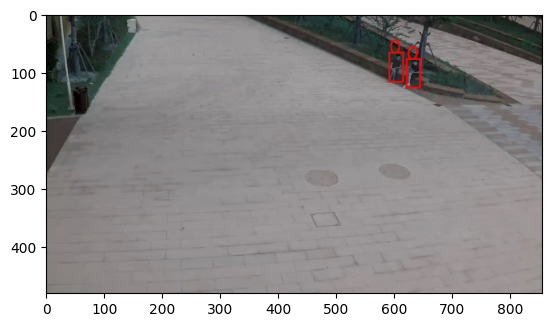

In [14]:
boxes, labels, scores = res
img_viz = img.copy()
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box.astype(np.uint16)
    img_viz = cv2.rectangle(img_viz,[x1,y1],[x2,y2],(255,0,0),2,2)
    img_viz = cv2.putText(img_viz, str(label), [x1,y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, 2)
plt.imshow(img_viz)

In [1]:
import os
import numpy as np
import torch
import argparse
import sys
sys.path.append('./dino-tracker')
from dino_tracker import DINOTracker
from models.model_inference import ModelInference
from data.data_utils import get_grid_query_points

device = "cuda:0" if torch.cuda.is_available() else "cpu"


@torch.no_grad()
def run(args):
    dino_tracker = DINOTracker(args)
    dino_tracker.load_fg_masks()
    model = dino_tracker.get_model()
    if args.iter is not None:
        model.load_weights(args.iter)

    grid_trajectories_dir = dino_tracker.grid_trajectories_dir
    grid_occlusions_dir = dino_tracker.grid_occlusions_dir
    os.makedirs(grid_trajectories_dir, exist_ok=True)
    os.makedirs(grid_occlusions_dir, exist_ok=True)

    model_inference = ModelInference(
        model=model,
        range_normalizer=dino_tracker.range_normalizer,
        anchor_cosine_similarity_threshold=dino_tracker.config['anchor_cosine_similarity_threshold'],
        cosine_similarity_threshold=dino_tracker.config['cosine_similarity_threshold'],
    )

    orig_video_h, orig_video_w = dino_tracker.orig_video_res_h, dino_tracker.orig_video_res_w
    model_video_h, model_video_w = model.video.shape[-2], model.video.shape[-1]

    segm_mask = dino_tracker.fg_masks[args.start_frame].to(device) if args.use_segm_mask else None # H x W / None
    grid_query_points = get_grid_query_points((orig_video_h, orig_video_w), segm_mask=segm_mask, device=device, interval=args.interval, query_frame=args.start_frame)
    grid_query_points = grid_query_points * torch.tensor([model_video_w / orig_video_w, model_video_h / orig_video_h, 1.0]).to(device) # resizes query points to model resolution

    grid_trajectories, grid_occlusions = model_inference.infer(grid_query_points, batch_size=args.batch_size)
    np.save(os.path.join(grid_trajectories_dir, "grid_trajectories.npy"), grid_trajectories[..., :2].cpu().detach().numpy())
    np.save(os.path.join(grid_occlusions_dir, "grid_occlusions.npy"), grid_occlusions.cpu().detach().numpy())


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-f")
    parser.add_argument("--config", default="./dino-tracker/config/train.yaml", type=str)
    parser.add_argument("--data-path", default="./dino-tracker/dataset/horsejump", type=str)
    parser.add_argument("--iter", type=int, default=None, help="Iteration number of the model to load, if None, the last checkpoint is loaded.")
    parser.add_argument("--start-frame", type=int, default=0)
    parser.add_argument("--interval", type=int, default=10)
    parser.add_argument("--use-segm-mask", action="store_true", default=False)
    parser.add_argument("--batch-size", type=int, default=None)
    args = parser.parse_args()
    run(args)


AssertionError: 

In [3]:
#!pip install transformers
#!pip install faster_coco_eval
#!pip install calflops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.7/486.7 KB 4.1 MB/s eta 0:00:0000:0100:01


In [1]:
!cd dino-tracker && python3 ./preprocessing/main_preprocessing.py --config ./config/preprocessing.yaml --data-path ./dataset/horsejump

----- Running python3 ./preprocessing/extract_trajectories.py --frames-path ./dataset/horsejump/video --output-path ./dataset/horsejump/of_trajectories/trajectories.pt --min-trajectory-length 2 --threshold 1.5 --infer-res-size 476 854 --filter-using-direct-flow --direct-flow-threshold 2.5
Traceback (most recent call last):
  File "/projects/Deep-Learning-For-Computer-Vision-org/keypoint_tracking/dino-tracker/./preprocessing/extract_trajectories.py", line 16, in <module>
    from data.data_utils import (
ModuleNotFoundError: No module named 'data'
----- Running python3 ./preprocessing/save_dino_embed_video.py --data-path ./dataset/horsejump --config ./config/preprocessing.yaml
Traceback (most recent call last):
  File "/projects/Deep-Learning-For-Computer-Vision-org/keypoint_tracking/dino-tracker/./preprocessing/save_dino_embed_video.py", line 5, in <module>
    from data.data_utils import load_video
ModuleNotFoundError: No module named 'data'
Masks already exist, skipping...
----- Runn

In [9]:
from raw_dino_match import RawDinoMatcher, token_to_pixel_coords
imgA    ='/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/frames/01_068/000.jpg'
imgB    = '/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/frames/01_068/005.jpg'
points  = []
matcher = RawDinoMatcher()

if args.points is None:
    matches_token, _, meta = matcher.dense_match(args.imgA, args.imgB)
    # Convert token matches to pixel coordinates for visualization if you like:
    px = token_to_pixel_coords(matches_token.reshape(-1,2), meta["patch_stride"])
    print(f"[dense] token grid: A={meta['Wa']}x{meta['Ha']} -> B={meta['Wb']}x{meta['Hb']}")
    print("Example first 10 matched pixels in B:\n", px[:10])
else:
    pts = []
    for p in args.points.split(","):
        x,y = p.split(":")
        pts.append([float(x), float(y)])
    pts = np.asarray(pts, dtype=float)
    # Ensure your provided points correspond to the model's resized size (img_size x img_size)
    out = matcher.track_points(args.imgA, args.imgB, pts)
    print("[points] matched pixel coords in B (approx):")
    for (x,y) in out:
        print(f"{x:.1f},{y:.1f}")


Writing raw_dino_match.py


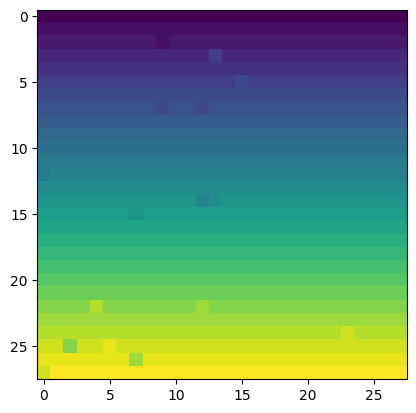

In [8]:
from matplotlib import pyplot as plt
plt.scatter(matches_token[:,:,1], matches_token[:,:,1])

In [3]:
feat = matcher._prep(args.imgA)

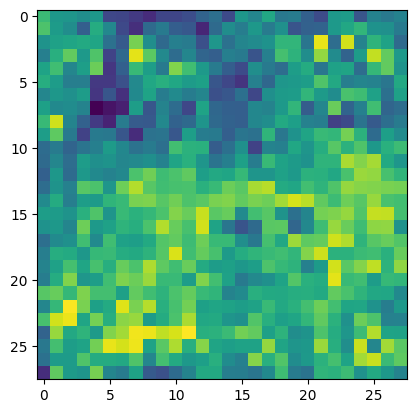

In [6]:
from matplotlib import pyplot as plt
plt.imshow(feat[0][0].detach().cpu().numpy())

In [3]:
import glob
glob.glob(f'/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/frames/01_068/*')[:2]

['/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/frames/01_068/000.jpg',
 '/media/irfan/TRANSCEND/camera_data/stech/shanghaitech/training/frames/01_068/001.jpg']